<a href="https://colab.research.google.com/github/Suraba03/ml_san_francisco_permits/blob/main/san_fancisco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import data and first glance

In [25]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [26]:
!ls

drive  sample_data


In [162]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/san_francisco/Building_Permits.csv', low_memory=False)

In [28]:
pd.set_option('display.max_columns', None)

In [29]:
df.head()

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,Unit,Unit Suffix,Description,Current Status,Current Status Date,Filed Date,Issued Date,Completed Date,First Construction Document Date,Structural Notification,Number of Existing Stories,Number of Proposed Stories,Voluntary Soft-Story Retrofit,Fire Only Permit,Permit Expiration Date,Estimated Cost,Revised Cost,Existing Use,Existing Units,Proposed Use,Proposed Units,Plansets,TIDF Compliance,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
0,201505065519,4,sign - erect,05/06/2015,0326,023,140,NaN,Ellis,St,NaN,NaN,"ground fl facade: to erect illuminated, electr...",expired,12/21/2017,05/06/2015,11/09/2015,NaN,11/09/2015,NaN,6.0,NaN,NaN,NaN,11/03/2016,4000.0,4000.0,tourist hotel/motel,143.0,NaN,NaN,2.0,NaN,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.785719256680785, -122.40852313194863)",1380611233945
1,201604195146,4,sign - erect,04/19/2016,0306,007,440,NaN,Geary,St,0.0,NaN,remove (e) awning and associated signs.,issued,08/03/2017,04/19/2016,08/03/2017,NaN,08/03/2017,NaN,7.0,NaN,NaN,NaN,12/03/2017,1.0,500.0,tourist hotel/motel,NaN,NaN,NaN,2.0,NaN,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.78733980600732, -122.41063199757738)",1420164406718
2,201605278609,3,additions alterations or repairs,05/27/2016,0595,203,1647,NaN,Pacific,Av,NaN,NaN,installation of separating wall,withdrawn,09/26/2017,05/27/2016,NaN,NaN,NaN,NaN,6.0,6.0,NaN,NaN,NaN,20000.0,NaN,retail sales,39.0,retail sales,39.0,2.0,NaN,1.0,constr type 1,1.0,constr type 1,NaN,3.0,Russian Hill,94109.0,"(37.7946573324287, -122.42232562979227)",1424856504716
3,201611072166,8,otc alterations permit,11/07/2016,0156,011,1230,NaN,Pacific,Av,0.0,NaN,repair dryrot & stucco at front of bldg.,complete,07/24/2017,11/07/2016,07/18/2017,07/24/2017,07/18/2017,NaN,2.0,2.0,NaN,NaN,07/13/2018,2000.0,2000.0,1 family dwelling,1.0,1 family dwelling,1.0,2.0,NaN,5.0,wood frame (5),5.0,wood frame (5),NaN,3.0,Nob Hill,94109.0,"(37.79595867909168, -122.41557405519474)",1443574295566
4,201611283529,6,demolitions,11/28/2016,0342,001,950,NaN,Market,St,NaN,NaN,demolish retail/office/commercial 3-story buil...,issued,12/01/2017,11/28/2016,12/01/2017,NaN,11/20/2017,NaN,3.0,NaN,NaN,NaN,12/01/2018,100000.0,100000.0,retail sales,NaN,NaN,NaN,2.0,NaN,3.0,constr type 3,NaN,NaN,NaN,6.0,Tenderloin,94102.0,"(37.78315261897309, -122.40950883997789)",144548169992


In [30]:
df.shape

(198900, 43)

# preprocessing

## Zero stage

let's remove white spaces from columns names

In [31]:
df = df.rename(lambda name: name.replace(" ", ""), axis='columns')

let's divide features list into two groups: numerical and categorical

In [32]:
num_cols = [col for col in df.columns if "int" in str(df[col].dtype) or "float" in str(df[col].dtype)]
cat_cols = [col for col in df.columns if "object" == str(df[col].dtype) and col != "CurrentStatus"]
print(num_cols)
print(cat_cols)

['PermitType', 'StreetNumber', 'Unit', 'NumberofExistingStories', 'NumberofProposedStories', 'EstimatedCost', 'RevisedCost', 'ExistingUnits', 'ProposedUnits', 'Plansets', 'ExistingConstructionType', 'ProposedConstructionType', 'SupervisorDistrict', 'Zipcode', 'RecordID']
['PermitNumber', 'PermitTypeDefinition', 'PermitCreationDate', 'Block', 'Lot', 'StreetNumberSuffix', 'StreetName', 'StreetSuffix', 'UnitSuffix', 'Description', 'CurrentStatusDate', 'FiledDate', 'IssuedDate', 'CompletedDate', 'FirstConstructionDocumentDate', 'StructuralNotification', 'VoluntarySoft-StoryRetrofit', 'FireOnlyPermit', 'PermitExpirationDate', 'ExistingUse', 'ProposedUse', 'TIDFCompliance', 'ExistingConstructionTypeDescription', 'ProposedConstructionTypeDescription', 'SitePermit', 'Neighborhoods-AnalysisBoundaries', 'Location']


In [33]:
target = "CurrentStatus"

these CurrentStatus values are useless because they are still in process, so that let's **drop them**

In [34]:
df = df[(df['CurrentStatus'] != 'filed') &
       (df['CurrentStatus'] != 'withdrawn') &
       (df['CurrentStatus'] != 'expired') &
       (df['CurrentStatus'] != 'plancheck') &
       (df['CurrentStatus'] != 'disapproved') &
       (df['CurrentStatus'] != 'appeal') ]

In [35]:
df.shape

(183713, 43)

Well we've lost apprx 15k rows, not so bad

Now let's divide values in **CurrentStatus** into two groups:
+ positive (value 1): application was rejected))
+ negative (value 0): application was approved

So lets consider ```[cancelled, suspend, revoked]``` as a **rejected** applications and ```[complete, issued, approved, reinstated, incomplete]``` as **approved** ones.

In [36]:
df['CurrentStatus'] = df['CurrentStatus'].map({'cancelled': 1, 'suspend': 1, 'revoked': 1,
                                                 'complete': 0, 'issued': 0, 'approved': 0, 
                                                 'reinstated': 0, 'incomplete': 0});

In [37]:
df['CurrentStatus'] = df['CurrentStatus'].astype('int64');

In [38]:
import seaborn as sns

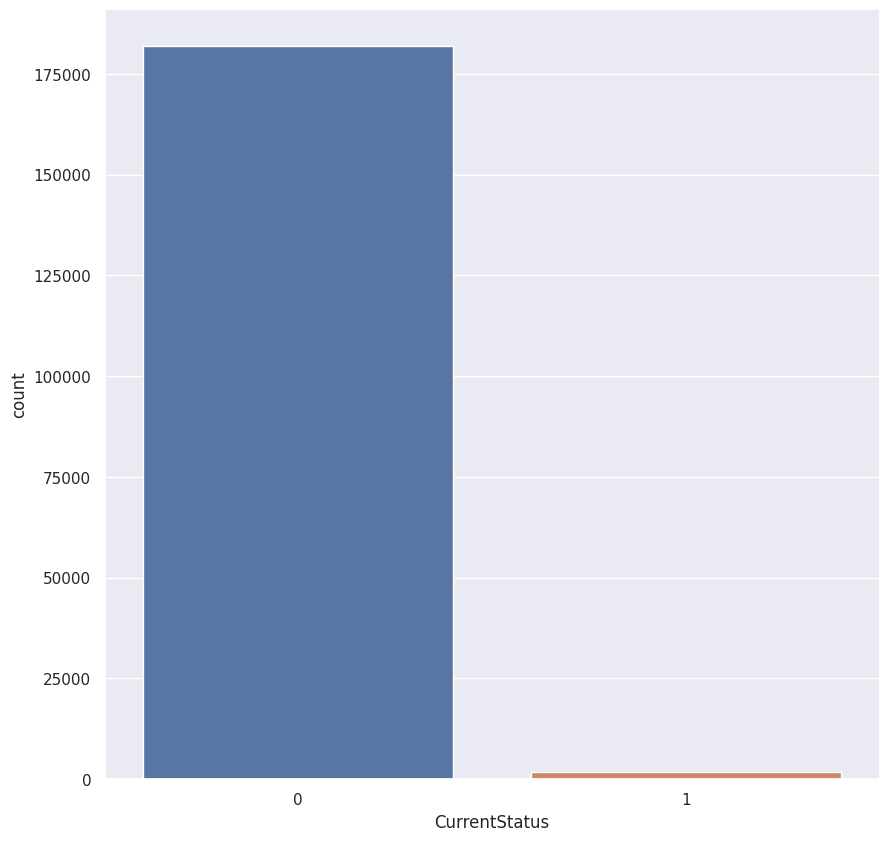

In [39]:
sns.set(rc={'figure.figsize':(10,10)})
sns.countplot(x=target, data=df);

In [40]:
df[target].value_counts() / df.shape[0]

0    0.990316
1    0.009684
Name: CurrentStatus, dtype: float64

just a sanity check

In [41]:
set(num_cols+cat_cols + [target]) == set(df.columns)

True

## Missing values (new)

In [42]:
df.head()

,PermitNumber,PermitType,PermitTypeDefinition,PermitCreationDate,Block,Lot,StreetNumber,StreetNumberSuffix,StreetName,StreetSuffix,Unit,UnitSuffix,Description,CurrentStatus,CurrentStatusDate,FiledDate,IssuedDate,CompletedDate,FirstConstructionDocumentDate,StructuralNotification,NumberofExistingStories,NumberofProposedStories,VoluntarySoft-StoryRetrofit,FireOnlyPermit,PermitExpirationDate,EstimatedCost,RevisedCost,ExistingUse,ExistingUnits,ProposedUse,ProposedUnits,Plansets,TIDFCompliance,ExistingConstructionType,ExistingConstructionTypeDescription,ProposedConstructionType,ProposedConstructionTypeDescription,SitePermit,SupervisorDistrict,Neighborhoods-AnalysisBoundaries,Zipcode,Location,RecordID
1,201604195146,4,sign - erect,04/19/2016,0306,007,440,NaN,Geary,St,0.0,NaN,remove (e) awning and associated signs.,0,08/03/2017,04/19/2016,08/03/2017,NaN,08/03/2017,NaN,7.0,NaN,NaN,NaN,12/03/2017,1.0,500.0,tourist hotel/motel,NaN,NaN,NaN,2.0,NaN,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.78733980600732, -122.41063199757738)",1420164406718
3,201611072166,8,otc alterations permit,11/07/2016,0156,011,1230,NaN,Pacific,Av,0.0,NaN,repair dryrot & stucco at front of bldg.,0,07/24/2017,11/07/2016,07/18/2017,07/24/2017,07/18/2017,NaN,2.0,2.0,NaN,NaN,07/13/2018,2000.0,2000.0,1 family dwelling,1.0,1 family dwelling,1.0,2.0,NaN,5.0,wood frame (5),5.0,wood frame (5),NaN,3.0,Nob Hill,94109.0,"(37.79595867909168, -122.41557405519474)",1443574295566
4,201611283529,6,demolitions,11/28/2016,0342,001,950,NaN,Market,St,NaN,NaN,demolish retail/office/commercial 3-story buil...,0,12/01/2017,11/28/2016,12/01/2017,NaN,11/20/2017,NaN,3.0,NaN,NaN,NaN,12/01/2018,100000.0,100000.0,retail sales,NaN,NaN,NaN,2.0,NaN,3.0,constr type 3,NaN,NaN,NaN,6.0,Tenderloin,94102.0,"(37.78315261897309, -122.40950883997789)",144548169992
5,201706149344,8,otc alterations permit,06/14/2017,4105,009,800,NaN,Indiana,St,NaN,NaN,evac maps,0,07/06/2017,06/14/2017,07/06/2017,NaN,07/06/2017,NaN,5.0,5.0,NaN,Y,07/01/2018,4000.0,4000.0,apartments,326.0,apartments,326.0,2.0,NaN,1.0,constr type 1,1.0,constr type 1,NaN,10.0,Potrero Hill,94107.0,"(37.75922331346539, -122.39170402628598)",1466911170855
6,201706300814,8,otc alterations permit,06/30/2017,1739,020,1291,NaN,11th,Av,0.0,NaN,re-roofing,0,07/12/2017,06/30/2017,06/30/2017,07/12/2017,06/30/2017,NaN,3.0,3.0,NaN,NaN,06/25/2018,12000.0,12000.0,apartments,5.0,apartments,5.0,0.0,NaN,5.0,wood frame (5),5.0,wood frame (5),NaN,5.0,Inner Sunset,94122.0,"(37.764145640138565, -122.46875112470363)",1468970403692


In [ ]:
# df2 = df.drop(['PermitNumber', 'PermitType', 'StreetSuffix',
#                 'PermitExpirationDate', 'ExistingConstructionType',
#                 'ProposedConstructionType', 'Zipcode', 'Location', 'RecordID'], axis=1)

In [96]:
indices = df['PermitNumber'].str.len() < 8

# get only positive pledges (using their indexes)
df.loc[indices].head()

,PermitNumber,PermitType,PermitTypeDefinition,PermitCreationDate,Block,Lot,StreetNumber,StreetNumberSuffix,StreetName,StreetSuffix,Unit,UnitSuffix,Description,CurrentStatus,CurrentStatusDate,FiledDate,IssuedDate,CompletedDate,FirstConstructionDocumentDate,StructuralNotification,NumberofExistingStories,NumberofProposedStories,VoluntarySoft-StoryRetrofit,FireOnlyPermit,PermitExpirationDate,EstimatedCost,RevisedCost,ExistingUse,ExistingUnits,ProposedUse,ProposedUnits,Plansets,TIDFCompliance,ExistingConstructionType,ExistingConstructionTypeDescription,ProposedConstructionType,ProposedConstructionTypeDescription,SitePermit,SupervisorDistrict,Neighborhoods-AnalysisBoundaries,Zipcode,Location,RecordID
7,M803667,8,otc alterations permit,06/30/2017,4789,014,1465,NaN,Revere,Av,NaN,NaN,streetspace,0,06/30/2017,06/30/2017,06/30/2017,NaN,06/30/2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,Bayview Hunters Point,94124.0,"(37.73005099023611, -122.38784938916618)",1469035175050
8,M804227,8,otc alterations permit,07/05/2017,1212,054,2094,NaN,Fell,St,NaN,NaN,street space permit,0,07/05/2017,07/05/2017,07/05/2017,NaN,07/05/2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,Lone Mountain/USF,94117.0,"(37.772393498502595, -122.45231466824669)",1469198253772
9,M804767,8,otc alterations permit,07/06/2017,1259,016,89,NaN,Alpine,Tr,NaN,NaN,street space,0,07/06/2017,07/06/2017,07/06/2017,NaN,07/06/2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,Haight Ashbury,94117.0,"(37.7691724293766, -122.43734859051908)",146932394171
10,M805287,8,otc alterations permit,07/06/2017,3541,001,106,NaN,Sanchez,St,NaN,NaN,street space,0,07/06/2017,07/06/2017,07/06/2017,NaN,07/06/2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,Castro/Upper Market,94114.0,"(37.767349757757145, -122.43140682973024)",1469445246849
11,M805907,8,otc alterations permit,07/07/2017,0829,021,675,NaN,Fell,St,NaN,NaN,street space,0,07/07/2017,07/07/2017,07/07/2017,NaN,07/07/2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,Hayes Valley,94102.0,"(37.774914087334544, -122.42886839796792)",146961582526


In [110]:
df.loc[~df['CompletedDate'].notnull()].CurrentStatus.value_counts()

0    84762
1     1767
Name: CurrentStatus, dtype: int64

**New boolean feature CompletedDate_was_missing**

In [111]:
df['CompletedDate_was_missing'] = df['CompletedDate'].isnull()

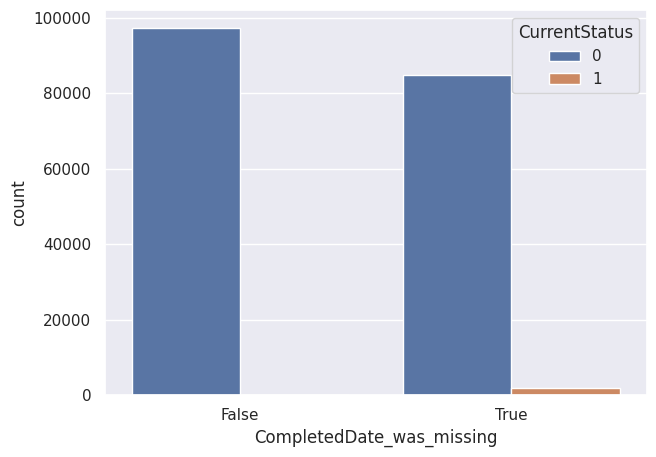

In [117]:
sns.countplot(x="CompletedDate_was_missing", hue="CurrentStatus", data=df);

In [119]:
df.loc[df['IssuedDate'].notnull()].CurrentStatus.value_counts()

0    181153
1      1436
Name: CurrentStatus, dtype: int64

In [120]:
df['IssuedDate_was_missing'] = df['IssuedDate'].isnull()

In [124]:
df.loc[~df['FirstConstructionDocumentDate'].notnull()].CurrentStatus.value_counts()

0    803
1    343
Name: CurrentStatus, dtype: int64

In [125]:
df['FirstConstructionDocumentDate_was_missing'] = df['FirstConstructionDocumentDate'].isnull()

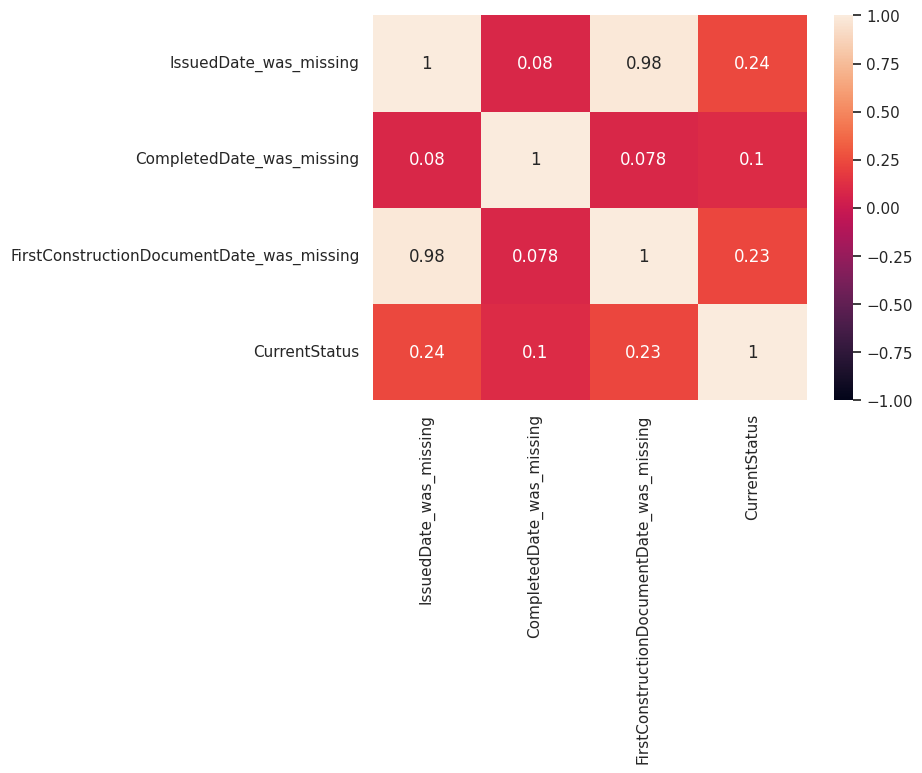

In [126]:
sns.set(rc={'figure.figsize':(7,5)})

corr_matrix = df[["IssuedDate_was_missing", 'CompletedDate_was_missing', 'FirstConstructionDocumentDate_was_missing', 'CurrentStatus']].corr()
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True);

**FirstConstructionDate correlates wiht issuedDate therefore we need to drop it**

In [127]:
df.drop(["FirstConstructionDocumentDate_was_missing"], axis=1, inplace=True)

In [137]:
df.loc[df['StructuralNotification'] == 'Y'].CurrentStatus.value_counts(),  df.loc[df['StructuralNotification'] == 'N'].CurrentStatus.value_counts()

(0    5231
 1     136
 Name: CurrentStatus, dtype: int64,
 0    176703
 1      1643
 Name: CurrentStatus, dtype: int64)

In [135]:
df['StructuralNotification'] = df['StructuralNotification'].fillna('N')

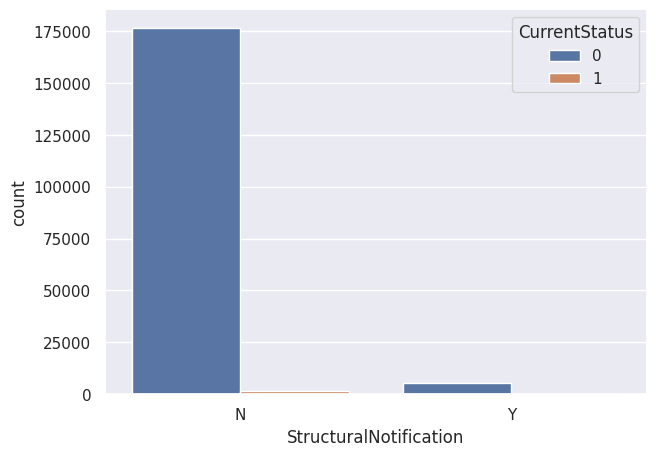

In [136]:
sns.countplot(x="StructuralNotification", hue="CurrentStatus", data=df);

In [142]:
df['StructuralNotification_is_yes'] = df['StructuralNotification'] == 'Y'

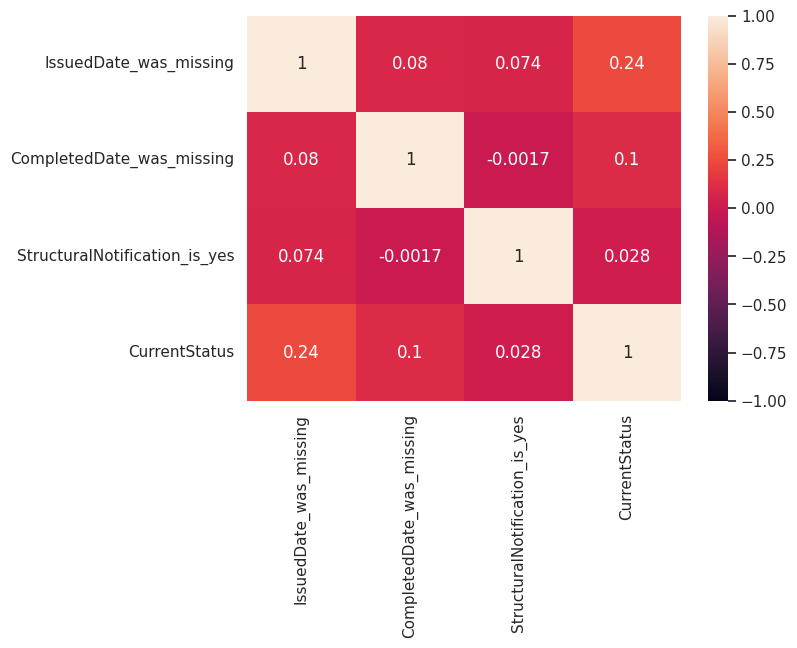

In [145]:
sns.set(rc={'figure.figsize':(7,5)})

corr_matrix = df[["IssuedDate_was_missing", 'CompletedDate_was_missing', 'StructuralNotification_is_yes', 'CurrentStatus']].corr()
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True);

In [152]:
df.loc[df['NumberofExistingStories'].notnull()].CurrentStatus.value_counts()

0    141161
1      1718
Name: CurrentStatus, dtype: int64

In [153]:
df['NumberofExistingStories_was_missing'] = df['NumberofExistingStories'].isnull()

In [181]:
df['NumberofStories_alteration'] = df['NumberofProposedStories'].fillna(0) - df['NumberofExistingStories'].fillna(0)

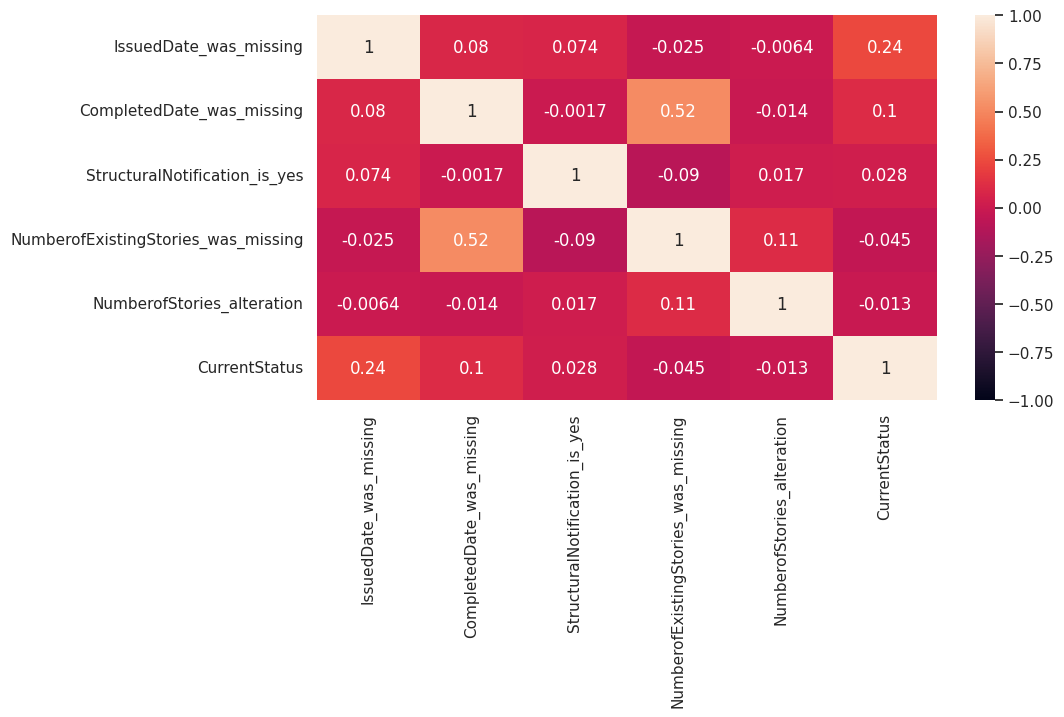

In [185]:
sns.set(rc={'figure.figsize':(10, 5)})

corr_matrix = df[["IssuedDate_was_missing", 'CompletedDate_was_missing', 'StructuralNotification_is_yes', 'NumberofExistingStories_was_missing', "NumberofStories_alteration", 'CurrentStatus']].corr()
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True);

In [188]:
df['VoluntarySoft-StoryRetrofit'].unique()

array([nan, 'Y'], dtype=object)

In [192]:
df.loc[~df['VoluntarySoft-StoryRetrofit'].isnull()].CurrentStatus.value_counts()

0    29
Name: CurrentStatus, dtype: int64

In [196]:
df['VoluntarySoft-StoryRetrofit_does_exist'] = df['VoluntarySoft-StoryRetrofit'].notnull()

In [203]:
df.loc[~df['FireOnlyPermit'].notnull()].CurrentStatus.value_counts()

0    163703
1      1716
Name: CurrentStatus, dtype: int64

In [204]:
df['FireOnlyPermit_does_exist'] = df['FireOnlyPermit'].notnull()

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183713 entries, 1 to 198899
Data columns (total 43 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   PermitNumber                         183713 non-null  object 
 1   PermitType                           183713 non-null  int64  
 2   PermitTypeDefinition                 183713 non-null  object 
 3   PermitCreationDate                   183713 non-null  object 
 4   Block                                183713 non-null  object 
 5   Lot                                  183713 non-null  object 
 6   StreetNumber                         183713 non-null  int64  
 7   StreetNumberSuffix                   1992 non-null    object 
 8   StreetName                           183713 non-null  object 
 9   StreetSuffix                         181131 non-null  object 
 10  Unit                                 27280 non-null   float64
 11  UnitSuffix   

In [209]:
df.loc[~df['PermitExpirationDate'].notnull()].CurrentStatus.value_counts()

0    37718
1      358
Name: CurrentStatus, dtype: int64

In [210]:
df['PermitExpirationDate_was_missing'] = df['PermitExpirationDate'].isnull()

In [240]:
df.loc[df['EstimatedCost'].notnull()].CurrentStatus.value_counts()

array([0.00000e+00, 1.00000e-02, 1.00000e+00, 2.00000e+00, 5.00000e+00,
       1.00000e+01, 1.30000e+01, 1.40000e+01, 2.00000e+01, 2.50000e+01,
       2.72400e+01, 4.00000e+01, 6.00000e+01, 8.00000e+01, 1.00000e+02,
       1.46880e+02, 1.59120e+02, 2.43660e+02, 2.46330e+02, 2.46660e+02,
       2.47860e+02, 2.65200e+02, 2.67240e+02, 2.67250e+02, 2.67280e+02,
       2.67860e+02, 2.74860e+02, 2.76240e+02, 3.67240e+02, 3.71280e+02,
       4.25000e+02, 4.38560e+02, 4.38960e+02, 4.46760e+02, 4.81440e+02,
       5.83440e+02, 6.34260e+02, 6.45550e+02, 6.45660e+02, 6.95000e+02,
       6.95640e+02, 7.90000e+02, 8.29560e+02, 8.44560e+02, 8.45580e+02,
       8.45880e+02, 9.09840e+02, 1.00000e+03, 1.02486e+03, 1.04448e+03,
       1.12404e+03, 1.16500e+03, 1.22052e+03, 1.50000e+03, 2.00000e+03,
       2.50000e+03, 3.00000e+03, 3.08400e+03, 4.00000e+03, 5.00000e+03,
       5.50000e+03, 5.80000e+03, 5.90000e+03, 6.00000e+03, 7.00000e+03,
       9.00000e+03, 9.23900e+03, 1.00000e+04, 1.01330e+04, 1.100

In [220]:
df['EstimatedCost_was_missing'] = df['EstimatedCost'].isnull()

In [223]:
df.drop(['PermitExpirationDate_was_missing'], axis=1, inplace=True)

In [225]:
df.drop(['NumberofExistingStories_was_missing'], axis=1, inplace=True)

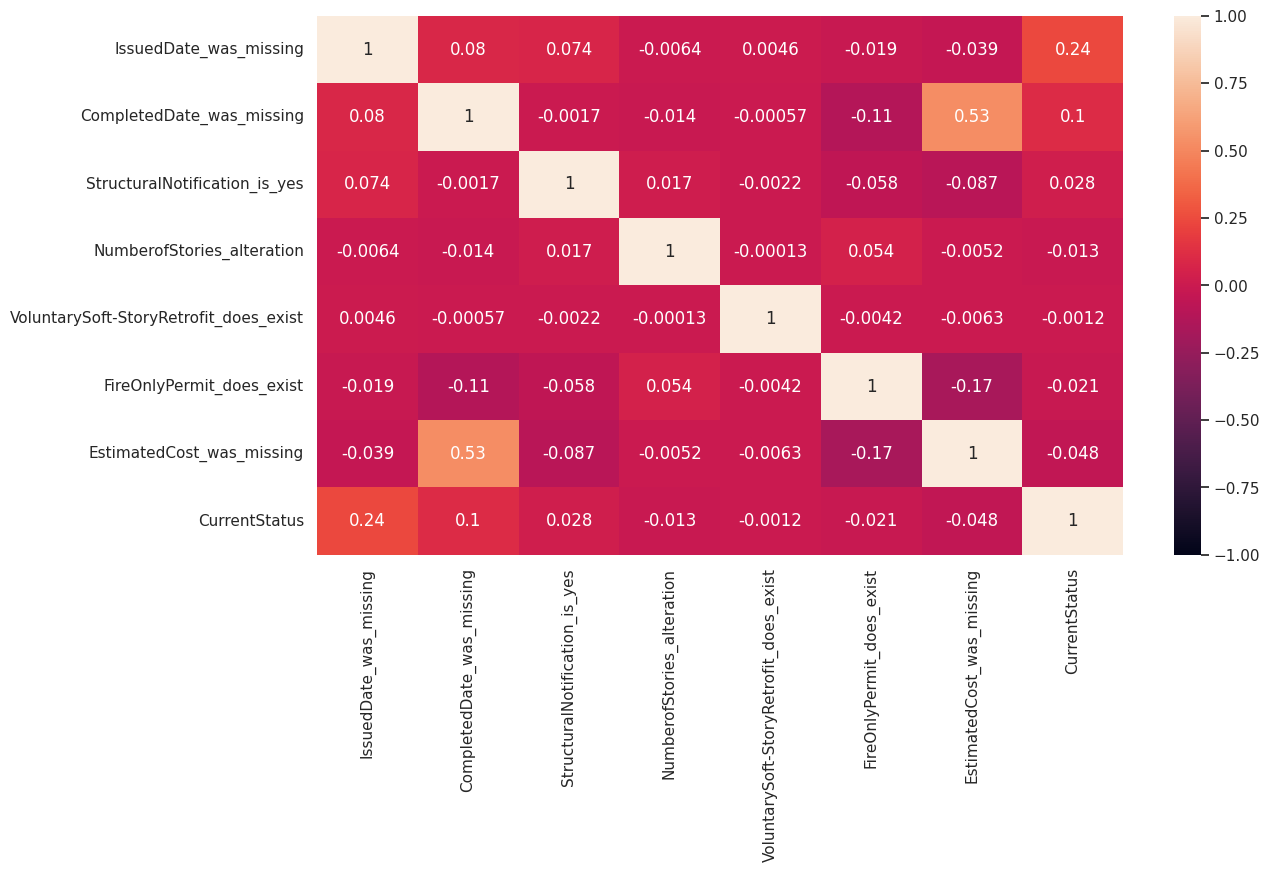

In [226]:
sns.set(rc={'figure.figsize':(13, 7)})

corr_matrix = df[["IssuedDate_was_missing", 'CompletedDate_was_missing', 'StructuralNotification_is_yes', "NumberofStories_alteration", 'VoluntarySoft-StoryRetrofit_does_exist', 'FireOnlyPermit_does_exist', 'EstimatedCost_was_missing', 'CurrentStatus']].corr()
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True);

Let's remove nans from column EstimatedCost

In [231]:
df1 = df[df['EstimatedCost'].notna()]

In [232]:
df1.shape

(146648, 50)

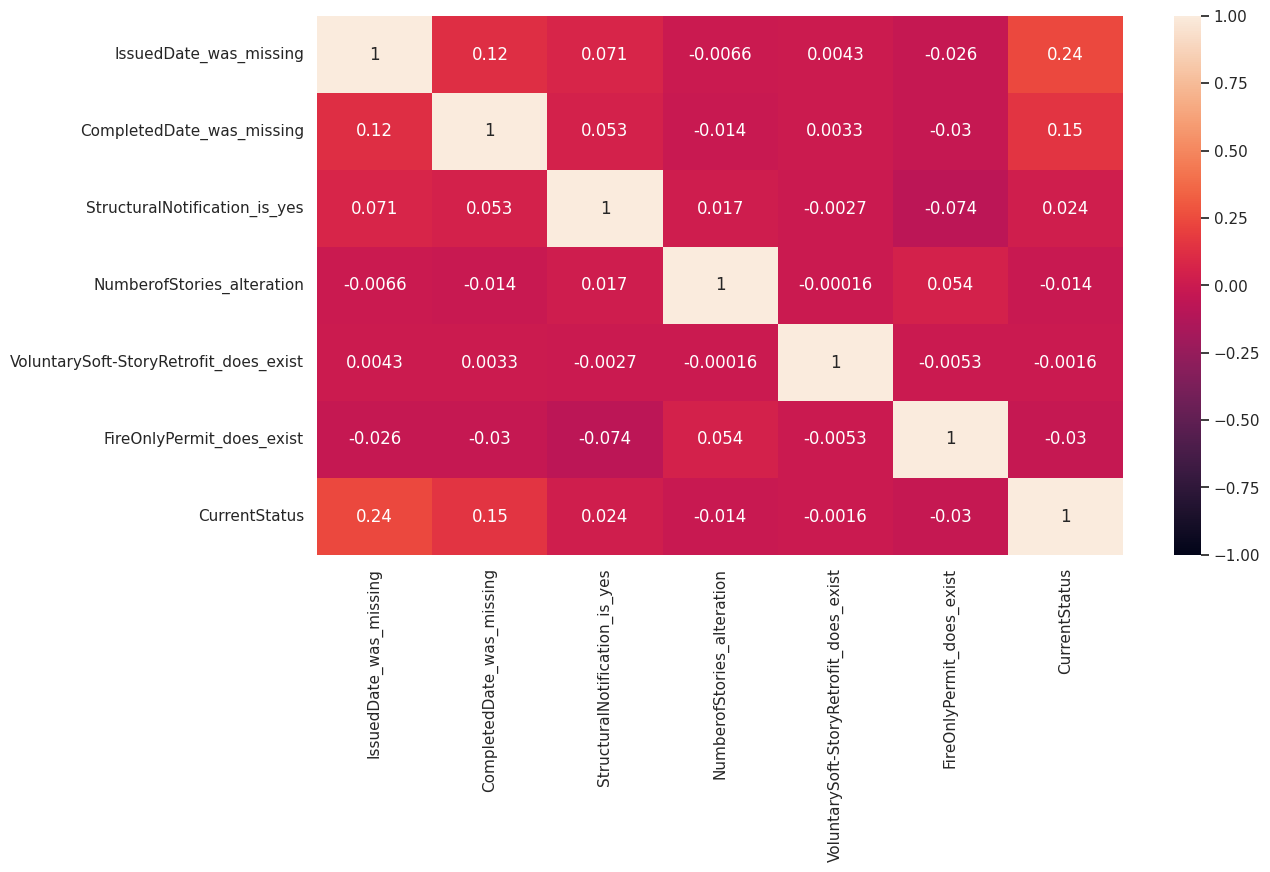

In [234]:
sns.set(rc={'figure.figsize':(13, 7)})

corr_matrix = df1[["IssuedDate_was_missing", 'CompletedDate_was_missing', 'StructuralNotification_is_yes', "NumberofStories_alteration", 'VoluntarySoft-StoryRetrofit_does_exist', 'FireOnlyPermit_does_exist', 'CurrentStatus']].corr()
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True);

In [258]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146275 entries, 1 to 198896
Data columns (total 51 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   PermitNumber                            146275 non-null  object 
 1   PermitType                              146275 non-null  int64  
 2   PermitTypeDefinition                    146275 non-null  object 
 3   PermitCreationDate                      146275 non-null  object 
 4   Block                                   146275 non-null  object 
 5   Lot                                     146275 non-null  object 
 6   StreetNumber                            146275 non-null  int64  
 7   StreetNumberSuffix                      1529 non-null    object 
 8   StreetName                              146275 non-null  object 
 9   StreetSuffix                            144176 non-null  object 
 10  Unit                                    2167

In [ ]:
a = df.loc[df['RevisedCost'].isnull()].EstimatedCost.unique()
a.sort()
a

Let's remove nans from column RevisedCost

In [243]:
df2 = df1[df1['RevisedCost'].notna()]

In [ ]:
sns.set(rc={'figure.figsize':(13, 7)})

corr_matrix = df1[["IssuedDate_was_missing", 'CompletedDate_was_missing', 'StructuralNotification_is_yes', "NumberofStories_alteration", 'VoluntarySoft-StoryRetrofit_does_exist', 'FireOnlyPermit_does_exist', 'CurrentStatus']].corr()
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True);

In [253]:
df2['Cost_alteration'] = df2['RevisedCost'] - df2['EstimatedCost']

<ipython-input-253-10df99f11613>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Cost_alteration'] = df2['RevisedCost'] - df2['EstimatedCost']


In [274]:
df2['ExistingUse'].map(lambda x : str(x)).unique()

array(['tourist hotel/motel', '1 family dwelling', 'retail sales',
       'apartments', 'church', 'office', 'vacant lot',
       '2 family dwelling', 'food/beverage hndlng', 'nan',
       'residential hotel', 'filling/service stn', 'clinics-medic/dental',
       'misc group residns.', 'hospital', 'barber/beauty salon',
       'warehouse,no frnitur', 'school', 'artist live/work',
       'manufacturing', 'garment shops', 'public assmbly other',
       'auto repairs', 'club', 'workshop commercial',
       'lending institution', 'museum', 'warehouse, furniture',
       'prkng garage/private', 'antenna', 'health studios & gym',
       'printing plant', 'parking lot', 'workshop residential',
       'storage shed', 'tower', 'mortuary', 'animal sale or care',
       'laundry/laundromat', 'nite club', 'paint store',
       'recreation bldg', 'theater', 'prkng garage/public', 'sign',
       'phone xchnge/equip', 'dance hall', 'muni carbarn', 'stadium',
       'automobile sales', 'power plant', '

In [275]:
b = df2['ExistingUse'].map(lambda x : str(x)).unique()
b.sort()
b

array(['1 family dwelling', '2 family dwelling', 'accessory cottage',
       'adult entertainment', 'ambulance service', 'amusement center',
       'animal sale or care', 'antenna', 'apartments', 'artist live/work',
       'auto repairs', 'automobile sales', 'barber/beauty salon',
       'bath house', 'building materials', 'car wash',
       'chemical processing', 'child care', 'christmas tree lot',
       'church', 'clinics-medic/dental', 'club', 'convalescent home',
       'dairies/dairy equip.', 'dance hall', 'day care center',
       'day care home 7 - 12', 'day care home gt 12',
       'day care home lt 7', 'day care, non-res', 'dry cleaners',
       'fence/retaining wall', 'filling/service stn',
       'food/beverage hndlng', 'garment shops', 'greenhouse',
       'health studios & gym', 'hospital', 'jail', 'laundry/laundromat',
       'lending institution', 'library', 'manufacturing',
       'massage parlor', 'meat/produce marts', 'misc group residns.',
       'mortuary', 'moving

In [276]:
c = df2['ProposedUse'].map(lambda x : str(x)).unique()
c.sort()
c

array(['1 family dwelling', '2 family dwelling', 'accessory cottage',
       'adult entertainment', 'ambulance service', 'amusement center',
       'animal sale or care', 'antenna', 'apartments', 'artist live/work',
       'auto repairs', 'automobile sales', 'barber/beauty salon',
       'bath house', 'building materials', 'car wash',
       'chemical processing', 'child care', 'christmas tree lot',
       'church', 'clinics-medic/dental', 'club', 'convalescent home',
       'dairies/dairy equip.', 'dance hall', 'day care center',
       'day care home 7 - 12', 'day care home gt 12',
       'day care home lt 7', 'day care, non-res', 'dry cleaners',
       'fence/retaining wall', 'filling/service stn',
       'food/beverage hndlng', 'garment shops', 'greenhouse',
       'health studios & gym', 'hospital', 'jail', 'laundry/laundromat',
       'lending institution', 'library', 'manufacturing',
       'massage parlor', 'meat/produce marts', 'misc group residns.',
       'mortuary', 'moving

In [278]:
#!pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [279]:
import fuzzywuzzy
from fuzzywuzzy import process

/usr/local/lib/python3.9/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


to delete: StreetNumberSuffix, Unit, UnitSuffix, CompletedDate (added binary feature), FirstConstructionDocumentDate (because of correlation), StructuralNotification (binary feature added), NumberofProposedStories, NumberofExistingStories (difference btwn prop and exis added), VoluntarySoft-StoryRetrofit (binary feature added), 

## deal with missing values

In [ ]:
df.info()

In [ ]:
df['EstimatedCost'].count()

146648

In [ ]:
list_to_drop = []
for col in num_cols + cat_cols + [target]:
    if df[col].count() < 130000:
        list_to_drop.append(col)
df2 = df.drop(list_to_drop, axis=1)

In [ ]:
df2[df2['CurrentStatus'] == 1].shape

(1779, 34)

In [ ]:
df2[df2['CurrentStatus'] == 0].count()

In [ ]:
df2[df2[target] == 1].info()

In [ ]:
df2[df2[target] == 0].info()

In [ ]:
df2.info()

In [ ]:
df3 = df2.drop(['PermitNumber', 'PermitType', 'StreetSuffix', 'PermitExpirationDate', 'ExistingConstructionType', 'ProposedConstructionType', 'Zipcode', 'Location', 'RecordID'], axis=1)

In [ ]:
df_cbc = df2.drop(['PermitNumber', 'PermitType', 'StreetSuffix', 'PermitExpirationDate', 'ExistingConstructionType', 'ProposedConstructionType', 'Zipcode', 'Location', 'RecordID'], axis=1)

In [ ]:
df3.info()

In [ ]:
num_cols3 = [col for col in df3.columns if "int" in str(df3[col].dtype) or "float" in str(df3[col].dtype)]
cat_cols3 = [col for col in df3.columns if "object" == str(df3[col].dtype) and col != "CurrentStatus"]
print(num_cols3)
print(cat_cols3)

['StreetNumber', 'CurrentStatus', 'NumberofExistingStories', 'NumberofProposedStories', 'EstimatedCost', 'RevisedCost', 'ExistingUnits', 'ProposedUnits', 'Plansets', 'SupervisorDistrict']
['PermitTypeDefinition', 'PermitCreationDate', 'Block', 'Lot', 'StreetName', 'Description', 'CurrentStatusDate', 'FiledDate', 'IssuedDate', 'FirstConstructionDocumentDate', 'ExistingUse', 'ProposedUse', 'ExistingConstructionTypeDescription', 'ProposedConstructionTypeDescription', 'Neighborhoods-AnalysisBoundaries']


In [ ]:
sns.set(rc={'figure.figsize':(10,10)})
sns.countplot(x=target, data=df3);

In [ ]:
df2.PermitTypeDefinition.value_counts()

In [ ]:
df3[target].value_counts() / df3.shape[0]

0    0.990316
1    0.009684
Name: CurrentStatus, dtype: float64

In [ ]:
df3.info()

In [ ]:
df3.head()

In [ ]:
df3['StreetNumber_int'] = df3.StreetNumber.astype('int64')

In [ ]:
sns.scatterplot(data=df3, x="StreetNumber_int", y=target)

In [ ]:
sns.set(rc={'figure.figsize':(27,10)})

corr_matrix = df3[["StreetNumber_int"] + [target]].corr()
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True);

In [ ]:
columns_to_show1 = ['Block', 'Lot', 'StreetNumber', 'StreetName']
columns_to_show = ['StreetName']

df3.groupby([target])[columns_to_show].describe()

In [ ]:
df3.StreetName.unique()

In [ ]:
lst = []
for name in df3.StreetName.unique():
    cnts = list(df3[df3.StreetName == name][target].value_counts())
    #print(cnts)
    if len(cnts) == 1:
        if df3[df3.StreetName == name][target].unique()[0] == 0:
            lst.append((name, 0, cnts[0], 0))
        else:
            lst.append((name, 9999999, 0, cnts[0]))
    elif len(cnts) == 0: 
        lst.append((name, -1, 0, 0))
    else:    
        lst.append((name, cnts[1]/cnts[0], cnts[0], cnts[1]))

In [ ]:
lst.sort(key=(lambda x: x[1]), reverse=True)
lst

In [ ]:
lst[-50:-1]

In [ ]:
df3[df3[target] == 0].info()

In [ ]:
df3[df3[target] == 1].info()

In [ ]:
df3.drop_duplicates()

In [ ]:
df_without_nan_cols = df3.drop(['FirstConstructionDocumentDate'], axis=1)

In [ ]:
df_without_nan_cols.dropna(inplace=True)

In [ ]:
df_without_nan_cols.head()

# Models

## Baseline

In [ ]:
df3 = df3.dropna(axis=0)

In [ ]:
df3.head()

,PermitTypeDefinition,PermitCreationDate,Block,Lot,StreetNumber,StreetName,Description,CurrentStatus,CurrentStatusDate,FiledDate,IssuedDate,FirstConstructionDocumentDate,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUse,ExistingUnits,ProposedUse,ProposedUnits,Plansets,ExistingConstructionTypeDescription,ProposedConstructionTypeDescription,SupervisorDistrict,Neighborhoods-AnalysisBoundaries,StreetNumber_int
3,otc alterations permit,11/07/2016,0156,011,1230,Pacific,repair dryrot & stucco at front of bldg.,0,07/24/2017,11/07/2016,07/18/2017,07/18/2017,2.0,2.0,2000.0,2000.0,1 family dwelling,1.0,1 family dwelling,1.0,2.0,wood frame (5),wood frame (5),3.0,Nob Hill,1230
5,otc alterations permit,06/14/2017,4105,009,800,Indiana,evac maps,0,07/06/2017,06/14/2017,07/06/2017,07/06/2017,5.0,5.0,4000.0,4000.0,apartments,326.0,apartments,326.0,2.0,constr type 1,constr type 1,10.0,Potrero Hill,800
6,otc alterations permit,06/30/2017,1739,020,1291,11th,re-roofing,0,07/12/2017,06/30/2017,06/30/2017,06/30/2017,3.0,3.0,12000.0,12000.0,apartments,5.0,apartments,5.0,0.0,wood frame (5),wood frame (5),5.0,Inner Sunset,1291
24,otc alterations permit,08/08/2017,0542,039,1,Charlton,re-roofing,0,08/08/2017,08/08/2017,08/08/2017,08/08/2017,4.0,4.0,64650.0,64650.0,apartments,9.0,apartments,9.0,0.0,wood frame (5),wood frame (5),2.0,Marina,1
25,otc alterations permit,08/16/2017,1824,006,1435,29th,re-roofing,0,08/16/2017,08/16/2017,08/16/2017,08/16/2017,2.0,2.0,7000.0,7000.0,1 family dwelling,1.0,1 family dwelling,1.0,0.0,wood frame (5),wood frame (5),4.0,Sunset/Parkside,1435


<Axes: xlabel='CurrentStatus', ylabel='count'>

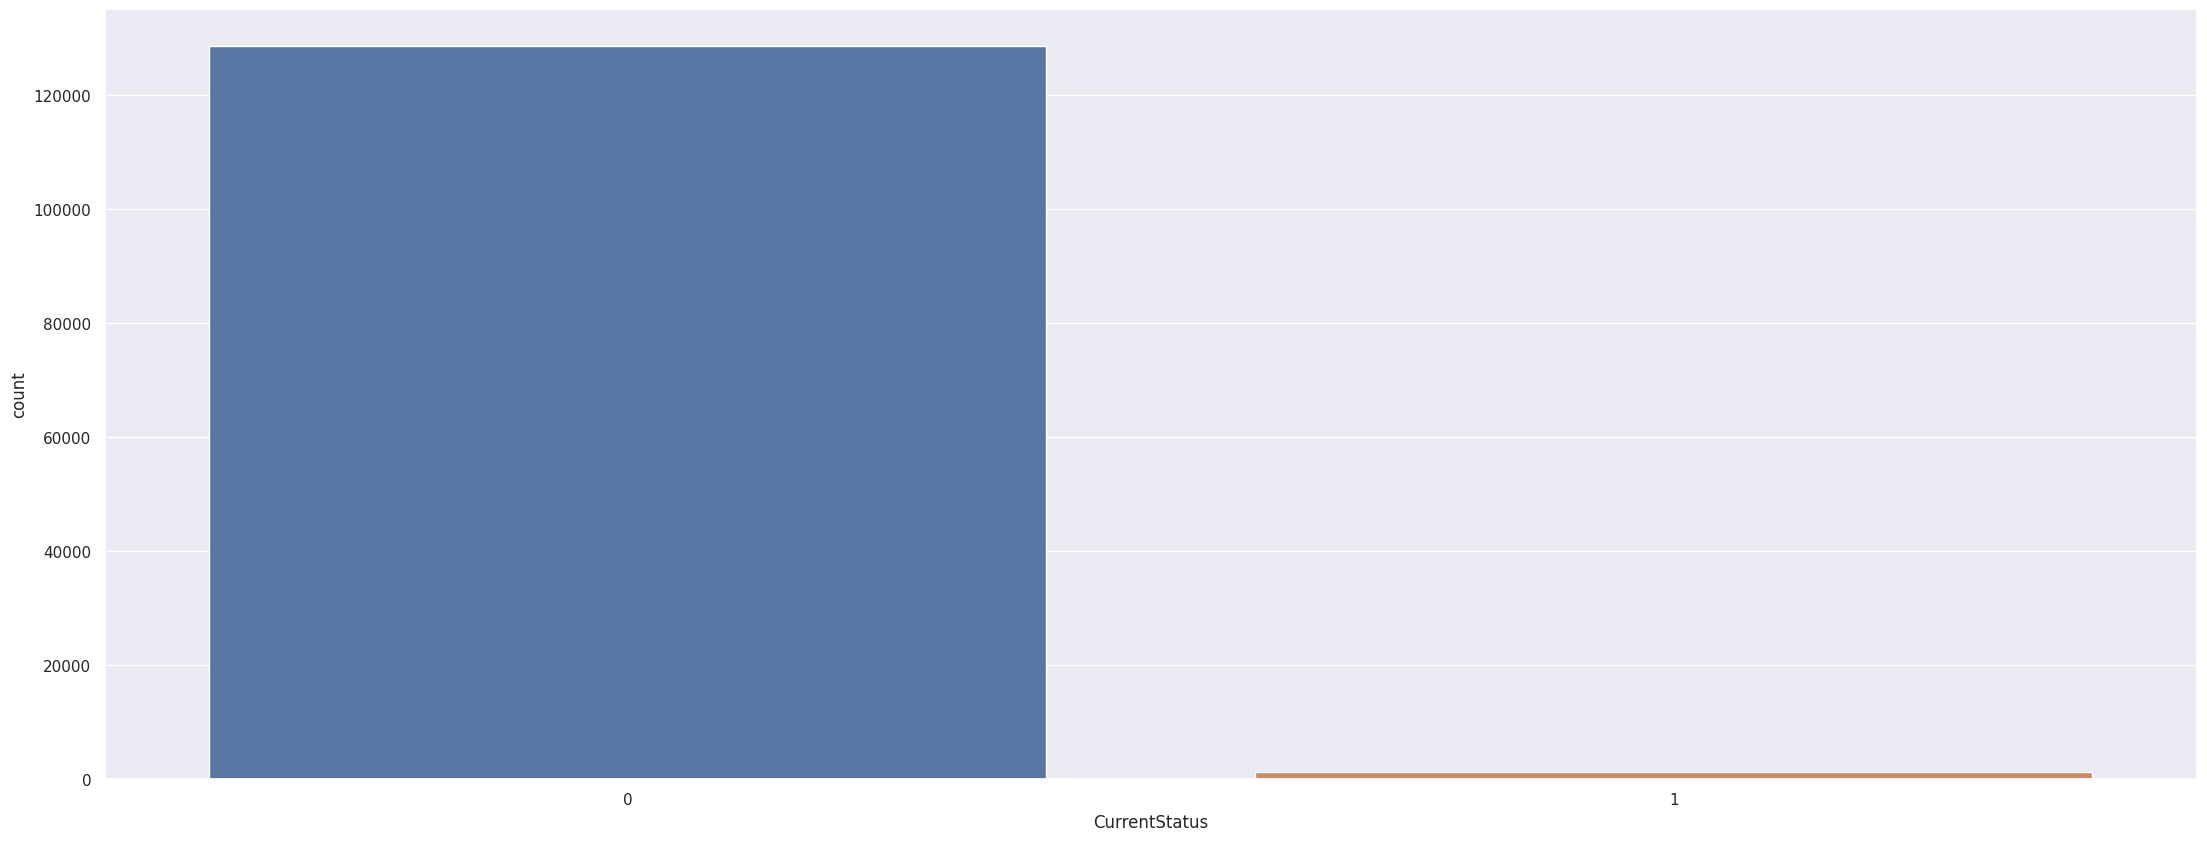

In [ ]:
sns.countplot(data=df3, x=target)

In [ ]:
df3[target].value_counts()[0] / df3[target].value_counts()[1]

97.65679574791191

In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129931 entries, 3 to 198882
Data columns (total 26 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   PermitTypeDefinition                 129931 non-null  object 
 1   PermitCreationDate                   129931 non-null  object 
 2   Block                                129931 non-null  object 
 3   Lot                                  129931 non-null  object 
 4   StreetNumber                         129931 non-null  int64  
 5   StreetName                           129931 non-null  object 
 6   Description                          129931 non-null  object 
 7   CurrentStatus                        129931 non-null  int64  
 8   CurrentStatusDate                    129931 non-null  object 
 9   FiledDate                            129931 non-null  object 
 10  IssuedDate                           129931 non-null  object 
 11  FirstConstruc

In [ ]:
for c in [col for col in df3.columns if "Date" in col]:
    df3[c] = pd.to_datetime(df3[c], format='%m/%d/%Y')

In [ ]:
df3.shape

(129931, 26)

In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129931 entries, 3 to 198882
Data columns (total 26 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   PermitTypeDefinition                 129931 non-null  object        
 1   PermitCreationDate                   129931 non-null  datetime64[ns]
 2   Block                                129931 non-null  object        
 3   Lot                                  129931 non-null  object        
 4   StreetNumber                         129931 non-null  int64         
 5   StreetName                           129931 non-null  object        
 6   Description                          129931 non-null  object        
 7   CurrentStatus                        129931 non-null  int64         
 8   CurrentStatusDate                    129931 non-null  datetime64[ns]
 9   FiledDate                            129931 non-null  datetime64[ns]
 

In [ ]:
df3.head()

,PermitTypeDefinition,PermitCreationDate,Block,Lot,StreetNumber,StreetName,Description,CurrentStatus,CurrentStatusDate,FiledDate,IssuedDate,FirstConstructionDocumentDate,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUse,ExistingUnits,ProposedUse,ProposedUnits,Plansets,ExistingConstructionTypeDescription,ProposedConstructionTypeDescription,SupervisorDistrict,Neighborhoods-AnalysisBoundaries,StreetNumber_int
3,otc alterations permit,2016-11-07,0156,011,1230,Pacific,repair dryrot & stucco at front of bldg.,0,2017-07-24,2016-11-07,2017-07-18,2017-07-18,2.0,2.0,2000.0,2000.0,1 family dwelling,1.0,1 family dwelling,1.0,2.0,wood frame (5),wood frame (5),3.0,Nob Hill,1230
5,otc alterations permit,2017-06-14,4105,009,800,Indiana,evac maps,0,2017-07-06,2017-06-14,2017-07-06,2017-07-06,5.0,5.0,4000.0,4000.0,apartments,326.0,apartments,326.0,2.0,constr type 1,constr type 1,10.0,Potrero Hill,800
6,otc alterations permit,2017-06-30,1739,020,1291,11th,re-roofing,0,2017-07-12,2017-06-30,2017-06-30,2017-06-30,3.0,3.0,12000.0,12000.0,apartments,5.0,apartments,5.0,0.0,wood frame (5),wood frame (5),5.0,Inner Sunset,1291
24,otc alterations permit,2017-08-08,0542,039,1,Charlton,re-roofing,0,2017-08-08,2017-08-08,2017-08-08,2017-08-08,4.0,4.0,64650.0,64650.0,apartments,9.0,apartments,9.0,0.0,wood frame (5),wood frame (5),2.0,Marina,1
25,otc alterations permit,2017-08-16,1824,006,1435,29th,re-roofing,0,2017-08-16,2017-08-16,2017-08-16,2017-08-16,2.0,2.0,7000.0,7000.0,1 family dwelling,1.0,1 family dwelling,1.0,0.0,wood frame (5),wood frame (5),4.0,Sunset/Parkside,1435


In [ ]:
for c in [col for col in df3.columns if "Date" in col]:
    df3[c] = df3[c].values.astype(np.int64)

In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129931 entries, 3 to 198882
Data columns (total 26 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   PermitTypeDefinition                 129931 non-null  object 
 1   PermitCreationDate                   129931 non-null  int64  
 2   Block                                129931 non-null  object 
 3   Lot                                  129931 non-null  object 
 4   StreetNumber                         129931 non-null  int64  
 5   StreetName                           129931 non-null  object 
 6   Description                          129931 non-null  object 
 7   CurrentStatus                        129931 non-null  int64  
 8   CurrentStatusDate                    129931 non-null  int64  
 9   FiledDate                            129931 non-null  int64  
 10  IssuedDate                           129931 non-null  int64  
 11  FirstConstruc

In [ ]:
df3.head()

,PermitTypeDefinition,PermitCreationDate,Block,Lot,StreetNumber,StreetName,Description,CurrentStatus,CurrentStatusDate,FiledDate,IssuedDate,FirstConstructionDocumentDate,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUse,ExistingUnits,ProposedUse,ProposedUnits,Plansets,ExistingConstructionTypeDescription,ProposedConstructionTypeDescription,SupervisorDistrict,Neighborhoods-AnalysisBoundaries,StreetNumber_int
3,otc alterations permit,1478476800000000000,0156,011,1230,Pacific,repair dryrot & stucco at front of bldg.,0,1500854400000000000,1478476800000000000,1500336000000000000,1500336000000000000,2.0,2.0,2000.0,2000.0,1 family dwelling,1.0,1 family dwelling,1.0,2.0,wood frame (5),wood frame (5),3.0,Nob Hill,1230
5,otc alterations permit,1497398400000000000,4105,009,800,Indiana,evac maps,0,1499299200000000000,1497398400000000000,1499299200000000000,1499299200000000000,5.0,5.0,4000.0,4000.0,apartments,326.0,apartments,326.0,2.0,constr type 1,constr type 1,10.0,Potrero Hill,800
6,otc alterations permit,1498780800000000000,1739,020,1291,11th,re-roofing,0,1499817600000000000,1498780800000000000,1498780800000000000,1498780800000000000,3.0,3.0,12000.0,12000.0,apartments,5.0,apartments,5.0,0.0,wood frame (5),wood frame (5),5.0,Inner Sunset,1291
24,otc alterations permit,1502150400000000000,0542,039,1,Charlton,re-roofing,0,1502150400000000000,1502150400000000000,1502150400000000000,1502150400000000000,4.0,4.0,64650.0,64650.0,apartments,9.0,apartments,9.0,0.0,wood frame (5),wood frame (5),2.0,Marina,1
25,otc alterations permit,1502841600000000000,1824,006,1435,29th,re-roofing,0,1502841600000000000,1502841600000000000,1502841600000000000,1502841600000000000,2.0,2.0,7000.0,7000.0,1 family dwelling,1.0,1 family dwelling,1.0,0.0,wood frame (5),wood frame (5),4.0,Sunset/Parkside,1435


to drop: block, lot, streetname, description

In [ ]:
df3.StreetNumber = df3.StreetNumber.astype(np.int64)

<Axes: >

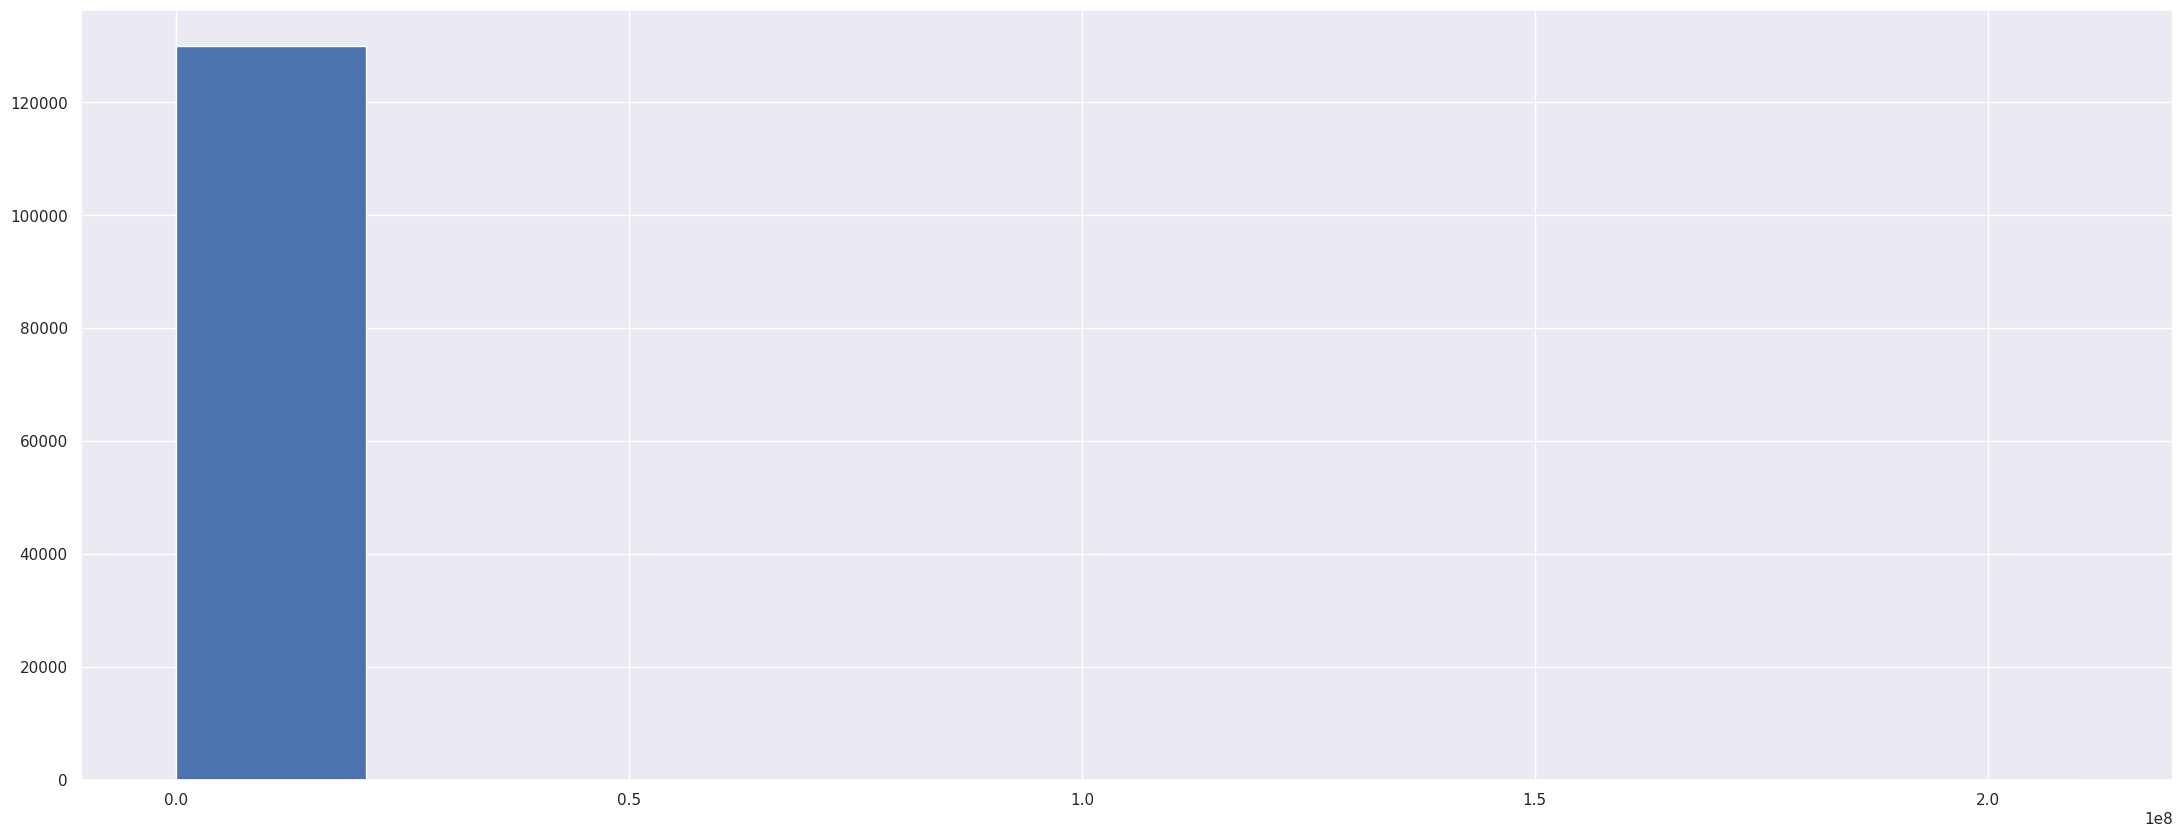

In [ ]:
df3.RevisedCost.hist()

In [ ]:
dct1 = df3.ExistingUse.value_counts().to_dict()
dct2 = df3.ProposedUse.value_counts().to_dict()

In [ ]:
#df3['ExistingUse'] = df3['ExistingUse'].map(dct1)
#df3['ProposedUse'] = df3['ProposedUse'].map(dct2)

In [ ]:
df3.head()

,PermitTypeDefinition,PermitCreationDate,Block,Lot,StreetNumber,StreetName,Description,CurrentStatus,CurrentStatusDate,FiledDate,IssuedDate,FirstConstructionDocumentDate,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUse,ExistingUnits,ProposedUse,ProposedUnits,Plansets,ExistingConstructionTypeDescription,ProposedConstructionTypeDescription,SupervisorDistrict,Neighborhoods-AnalysisBoundaries,StreetNumber_int
3,otc alterations permit,1478476800000000000,0156,011,1230,Pacific,repair dryrot & stucco at front of bldg.,0,1500854400000000000,1478476800000000000,1500336000000000000,1500336000000000000,2.0,2.0,2000.0,2000.0,1 family dwelling,1.0,1 family dwelling,1.0,2.0,wood frame (5),wood frame (5),3.0,Nob Hill,1230
5,otc alterations permit,1497398400000000000,4105,009,800,Indiana,evac maps,0,1499299200000000000,1497398400000000000,1499299200000000000,1499299200000000000,5.0,5.0,4000.0,4000.0,apartments,326.0,apartments,326.0,2.0,constr type 1,constr type 1,10.0,Potrero Hill,800
6,otc alterations permit,1498780800000000000,1739,020,1291,11th,re-roofing,0,1499817600000000000,1498780800000000000,1498780800000000000,1498780800000000000,3.0,3.0,12000.0,12000.0,apartments,5.0,apartments,5.0,0.0,wood frame (5),wood frame (5),5.0,Inner Sunset,1291
24,otc alterations permit,1502150400000000000,0542,039,1,Charlton,re-roofing,0,1502150400000000000,1502150400000000000,1502150400000000000,1502150400000000000,4.0,4.0,64650.0,64650.0,apartments,9.0,apartments,9.0,0.0,wood frame (5),wood frame (5),2.0,Marina,1
25,otc alterations permit,1502841600000000000,1824,006,1435,29th,re-roofing,0,1502841600000000000,1502841600000000000,1502841600000000000,1502841600000000000,2.0,2.0,7000.0,7000.0,1 family dwelling,1.0,1 family dwelling,1.0,0.0,wood frame (5),wood frame (5),4.0,Sunset/Parkside,1435


In [ ]:
s = df3.ExistingUse.value_counts()
s1 = df3.ProposedUse.value_counts()
l_q = list()
for elem in np.arange(0.1, 1, 0.1):
    l_q.append(s.quantile(elem))

l_q1 = list()
for elem in np.arange(0.1, 1, 0.1):
    l_q1.append(s.quantile(elem))

In [ ]:
l_q

[2.0,
 4.0,
 7.0,
 15.0,
 24.0,
 45.0,
 71.39999999999999,
 125.19999999999997,
 439.10000000000025]

In [ ]:
def f1(row, l_q):
    acc = 0
    for a in range(len(l_q)):
        if row > l_q[a]:
            acc += 1
    return acc

In [ ]:
#df3.ExistingUse = df3.ExistingUse.map(lambda x: f1(x, l_q))
#df3.ProposedUse = df3.ProposedUse.map(lambda x: f1(x, l_q1))

In [ ]:
df3.head(2)

,PermitTypeDefinition,PermitCreationDate,Block,Lot,StreetNumber,StreetName,Description,CurrentStatus,CurrentStatusDate,FiledDate,IssuedDate,FirstConstructionDocumentDate,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUse,ExistingUnits,ProposedUse,ProposedUnits,Plansets,ExistingConstructionTypeDescription,ProposedConstructionTypeDescription,SupervisorDistrict,Neighborhoods-AnalysisBoundaries,StreetNumber_int
3,otc alterations permit,1478476800000000000,0156,011,1230,Pacific,repair dryrot & stucco at front of bldg.,0,1500854400000000000,1478476800000000000,1500336000000000000,1500336000000000000,2.0,2.0,2000.0,2000.0,1 family dwelling,1.0,1 family dwelling,1.0,2.0,wood frame (5),wood frame (5),3.0,Nob Hill,1230
5,otc alterations permit,1497398400000000000,4105,009,800,Indiana,evac maps,0,1499299200000000000,1497398400000000000,1499299200000000000,1499299200000000000,5.0,5.0,4000.0,4000.0,apartments,326.0,apartments,326.0,2.0,constr type 1,constr type 1,10.0,Potrero Hill,800


In [ ]:
#df3.drop(['Block', 'Lot', 'StreetName', 'Description', 'StreetNumber_int'], axis=1, inplace=True)

In [ ]:
df3.Plansets.value_counts()

2.0       70293
0.0       59396
3.0         240
9000.0        1
4.0           1
Name: Plansets, dtype: int64

In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 3.2 MB/s eta 0:00:00


In [ ]:
import category_encoders as ce

In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129931 entries, 3 to 198882
Data columns (total 26 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   PermitTypeDefinition                 129931 non-null  object 
 1   PermitCreationDate                   129931 non-null  int64  
 2   Block                                129931 non-null  object 
 3   Lot                                  129931 non-null  object 
 4   StreetNumber                         129931 non-null  int64  
 5   StreetName                           129931 non-null  object 
 6   Description                          129931 non-null  object 
 7   CurrentStatus                        129931 non-null  int64  
 8   CurrentStatusDate                    129931 non-null  int64  
 9   FiledDate                            129931 non-null  int64  
 10  IssuedDate                           129931 non-null  int64  
 11  FirstConstruc

In [ ]:
ce_baseN4 = ce.BaseNEncoder(cols=['ExistingUse', 'ProposedUse'], base=4)
df3 = ce_baseN4.fit_transform(df3)

In [ ]:
df3.head()

,PermitTypeDefinition,PermitCreationDate,Block,Lot,StreetNumber,StreetName,Description,CurrentStatus,CurrentStatusDate,FiledDate,IssuedDate,FirstConstructionDocumentDate,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUse_0,ExistingUse_1,ExistingUse_2,ExistingUse_3,ExistingUnits,ProposedUse_0,ProposedUse_1,ProposedUse_2,ProposedUse_3,ProposedUnits,Plansets,ExistingConstructionTypeDescription,ProposedConstructionTypeDescription,SupervisorDistrict,Neighborhoods-AnalysisBoundaries,StreetNumber_int
3,otc alterations permit,1478476800000000000,0156,011,1230,Pacific,repair dryrot & stucco at front of bldg.,0,1500854400000000000,1478476800000000000,1500336000000000000,1500336000000000000,2.0,2.0,2000.0,2000.0,0,0,0,1,1.0,0,0,0,1,1.0,2.0,wood frame (5),wood frame (5),3.0,Nob Hill,1230
5,otc alterations permit,1497398400000000000,4105,009,800,Indiana,evac maps,0,1499299200000000000,1497398400000000000,1499299200000000000,1499299200000000000,5.0,5.0,4000.0,4000.0,0,0,0,2,326.0,0,0,0,2,326.0,2.0,constr type 1,constr type 1,10.0,Potrero Hill,800
6,otc alterations permit,1498780800000000000,1739,020,1291,11th,re-roofing,0,1499817600000000000,1498780800000000000,1498780800000000000,1498780800000000000,3.0,3.0,12000.0,12000.0,0,0,0,2,5.0,0,0,0,2,5.0,0.0,wood frame (5),wood frame (5),5.0,Inner Sunset,1291
24,otc alterations permit,1502150400000000000,0542,039,1,Charlton,re-roofing,0,1502150400000000000,1502150400000000000,1502150400000000000,1502150400000000000,4.0,4.0,64650.0,64650.0,0,0,0,2,9.0,0,0,0,2,9.0,0.0,wood frame (5),wood frame (5),2.0,Marina,1
25,otc alterations permit,1502841600000000000,1824,006,1435,29th,re-roofing,0,1502841600000000000,1502841600000000000,1502841600000000000,1502841600000000000,2.0,2.0,7000.0,7000.0,0,0,0,1,1.0,0,0,0,1,1.0,0.0,wood frame (5),wood frame (5),4.0,Sunset/Parkside,1435


In [ ]:
df3 = df3[(df3['Plansets'] != 4.0)]
df3 = df3[(df3['Plansets'] != 9000.0)]


In [ ]:
df3.Plansets.value_counts()

2.0    70293
0.0    59396
3.0      240
Name: Plansets, dtype: int64

In [ ]:
df3 = pd.get_dummies(df3, columns=['PermitTypeDefinition', 'Plansets', 'SupervisorDistrict'])

In [ ]:
df3.head()

,PermitCreationDate,Block,Lot,StreetNumber,StreetName,Description,CurrentStatus,CurrentStatusDate,FiledDate,IssuedDate,FirstConstructionDocumentDate,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUse_0,ExistingUse_1,ExistingUse_2,ExistingUse_3,ExistingUnits,ProposedUse_0,ProposedUse_1,ProposedUse_2,ProposedUse_3,ProposedUnits,ExistingConstructionTypeDescription,ProposedConstructionTypeDescription,Neighborhoods-AnalysisBoundaries,StreetNumber_int,PermitTypeDefinition_additions alterations or repairs,PermitTypeDefinition_new construction wood frame,PermitTypeDefinition_otc alterations permit,Plansets_0.0,Plansets_2.0,Plansets_3.0,SupervisorDistrict_1.0,SupervisorDistrict_2.0,SupervisorDistrict_3.0,SupervisorDistrict_4.0,SupervisorDistrict_5.0,SupervisorDistrict_6.0,SupervisorDistrict_7.0,SupervisorDistrict_8.0,SupervisorDistrict_9.0,SupervisorDistrict_10.0,SupervisorDistrict_11.0
3,1478476800000000000,0156,011,1230,Pacific,repair dryrot & stucco at front of bldg.,0,1500854400000000000,1478476800000000000,1500336000000000000,1500336000000000000,2.0,2.0,2000.0,2000.0,0,0,0,1,1.0,0,0,0,1,1.0,wood frame (5),wood frame (5),Nob Hill,1230,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
5,1497398400000000000,4105,009,800,Indiana,evac maps,0,1499299200000000000,1497398400000000000,1499299200000000000,1499299200000000000,5.0,5.0,4000.0,4000.0,0,0,0,2,326.0,0,0,0,2,326.0,constr type 1,constr type 1,Potrero Hill,800,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0
6,1498780800000000000,1739,020,1291,11th,re-roofing,0,1499817600000000000,1498780800000000000,1498780800000000000,1498780800000000000,3.0,3.0,12000.0,12000.0,0,0,0,2,5.0,0,0,0,2,5.0,wood frame (5),wood frame (5),Inner Sunset,1291,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
24,1502150400000000000,0542,039,1,Charlton,re-roofing,0,1502150400000000000,1502150400000000000,1502150400000000000,1502150400000000000,4.0,4.0,64650.0,64650.0,0,0,0,2,9.0,0,0,0,2,9.0,wood frame (5),wood frame (5),Marina,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
25,1502841600000000000,1824,006,1435,29th,re-roofing,0,1502841600000000000,1502841600000000000,1502841600000000000,1502841600000000000,2.0,2.0,7000.0,7000.0,0,0,0,1,1.0,0,0,0,1,1.0,wood frame (5),wood frame (5),Sunset/Parkside,1435,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
df3['StreetName'].value_counts()

Market        3498
California    3031
Mission       2472
Montgomery    1682
20th          1236
              ... 
Lessing          1
Toyon            1
13th             1
Clarion          1
Ignacio          1
Name: StreetName, Length: 1629, dtype: int64

In [ ]:
df3.drop(['Block', 'Lot', 'StreetName', 'Description'], axis=1, inplace=True)

In [ ]:
df3['ProposedConstructionTypeDescription'].value_counts()

wood frame (5)    99202
constr type 1     20577
constr type 3      7090
constr type 2      2765
constr type 4       295
Name: ProposedConstructionTypeDescription, dtype: int64

In [ ]:
ce_baseN4 = ce.BaseNEncoder(cols=['Neighborhoods-AnalysisBoundaries'], base=4)
df3 = ce_baseN4.fit_transform(df3)

In [ ]:
df3.head()

,PermitCreationDate,StreetNumber,CurrentStatus,CurrentStatusDate,FiledDate,IssuedDate,FirstConstructionDocumentDate,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUse_0,ExistingUse_1,ExistingUse_2,ExistingUse_3,ExistingUnits,ProposedUse_0,ProposedUse_1,ProposedUse_2,ProposedUse_3,ProposedUnits,ExistingConstructionTypeDescription,ProposedConstructionTypeDescription,Neighborhoods-AnalysisBoundaries_0,Neighborhoods-AnalysisBoundaries_1,Neighborhoods-AnalysisBoundaries_2,StreetNumber_int,PermitTypeDefinition_additions alterations or repairs,PermitTypeDefinition_new construction wood frame,PermitTypeDefinition_otc alterations permit,Plansets_0.0,Plansets_2.0,Plansets_3.0,SupervisorDistrict_1.0,SupervisorDistrict_2.0,SupervisorDistrict_3.0,SupervisorDistrict_4.0,SupervisorDistrict_5.0,SupervisorDistrict_6.0,SupervisorDistrict_7.0,SupervisorDistrict_8.0,SupervisorDistrict_9.0,SupervisorDistrict_10.0,SupervisorDistrict_11.0
3,1478476800000000000,1230,0,1500854400000000000,1478476800000000000,1500336000000000000,1500336000000000000,2.0,2.0,2000.0,2000.0,0,0,0,1,1.0,0,0,0,1,1.0,wood frame (5),wood frame (5),0,0,1,1230,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
5,1497398400000000000,800,0,1499299200000000000,1497398400000000000,1499299200000000000,1499299200000000000,5.0,5.0,4000.0,4000.0,0,0,0,2,326.0,0,0,0,2,326.0,constr type 1,constr type 1,0,0,2,800,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0
6,1498780800000000000,1291,0,1499817600000000000,1498780800000000000,1498780800000000000,1498780800000000000,3.0,3.0,12000.0,12000.0,0,0,0,2,5.0,0,0,0,2,5.0,wood frame (5),wood frame (5),0,0,3,1291,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
24,1502150400000000000,1,0,1502150400000000000,1502150400000000000,1502150400000000000,1502150400000000000,4.0,4.0,64650.0,64650.0,0,0,0,2,9.0,0,0,0,2,9.0,wood frame (5),wood frame (5),0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
25,1502841600000000000,1435,0,1502841600000000000,1502841600000000000,1502841600000000000,1502841600000000000,2.0,2.0,7000.0,7000.0,0,0,0,1,1.0,0,0,0,1,1.0,wood frame (5),wood frame (5),0,1,1,1435,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
df3 = pd.get_dummies(df3, columns=['ExistingConstructionTypeDescription', 'ProposedConstructionTypeDescription'])

In [ ]:
df3.head()

,PermitCreationDate,StreetNumber,CurrentStatus,CurrentStatusDate,FiledDate,IssuedDate,FirstConstructionDocumentDate,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUse_0,ExistingUse_1,ExistingUse_2,ExistingUse_3,ExistingUnits,ProposedUse_0,ProposedUse_1,ProposedUse_2,ProposedUse_3,ProposedUnits,Neighborhoods-AnalysisBoundaries_0,Neighborhoods-AnalysisBoundaries_1,Neighborhoods-AnalysisBoundaries_2,StreetNumber_int,PermitTypeDefinition_additions alterations or repairs,PermitTypeDefinition_new construction wood frame,PermitTypeDefinition_otc alterations permit,Plansets_0.0,Plansets_2.0,Plansets_3.0,SupervisorDistrict_1.0,SupervisorDistrict_2.0,SupervisorDistrict_3.0,SupervisorDistrict_4.0,SupervisorDistrict_5.0,SupervisorDistrict_6.0,SupervisorDistrict_7.0,SupervisorDistrict_8.0,SupervisorDistrict_9.0,SupervisorDistrict_10.0,SupervisorDistrict_11.0,ExistingConstructionTypeDescription_constr type 1,ExistingConstructionTypeDescription_constr type 2,ExistingConstructionTypeDescription_constr type 3,ExistingConstructionTypeDescription_constr type 4,ExistingConstructionTypeDescription_wood frame (5),ProposedConstructionTypeDescription_constr type 1,ProposedConstructionTypeDescription_constr type 2,ProposedConstructionTypeDescription_constr type 3,ProposedConstructionTypeDescription_constr type 4,ProposedConstructionTypeDescription_wood frame (5)
3,1478476800000000000,1230,0,1500854400000000000,1478476800000000000,1500336000000000000,1500336000000000000,2.0,2.0,2000.0,2000.0,0,0,0,1,1.0,0,0,0,1,1.0,0,0,1,1230,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
5,1497398400000000000,800,0,1499299200000000000,1497398400000000000,1499299200000000000,1499299200000000000,5.0,5.0,4000.0,4000.0,0,0,0,2,326.0,0,0,0,2,326.0,0,0,2,800,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
6,1498780800000000000,1291,0,1499817600000000000,1498780800000000000,1498780800000000000,1498780800000000000,3.0,3.0,12000.0,12000.0,0,0,0,2,5.0,0,0,0,2,5.0,0,0,3,1291,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
24,1502150400000000000,1,0,1502150400000000000,1502150400000000000,1502150400000000000,1502150400000000000,4.0,4.0,64650.0,64650.0,0,0,0,2,9.0,0,0,0,2,9.0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
25,1502841600000000000,1435,0,1502841600000000000,1502841600000000000,1502841600000000000,1502841600000000000,2.0,2.0,7000.0,7000.0,0,0,0,1,1.0,0,0,0,1,1.0,0,1,1,1435,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


## Scaling for logistic regression and LR

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

In [ ]:
X = df3.drop([target], axis=1)
y = df3[target]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((103943, 51), (25986, 51), (103943,), (25986,))

In [ ]:
t1 = X['PermitCreationDate'].dtype
t2 = X['NumberofExistingStories'].dtype

In [ ]:
num_cols = list()
for col in X.columns:
    if (X[col].dtype == t1 or X[col].dtype == t2) and "_" not in col:
        num_cols.append(col)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129929 entries, 3 to 198882
Data columns (total 51 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   PermitCreationDate                                     129929 non-null  int64  
 1   StreetNumber                                           129929 non-null  int64  
 2   CurrentStatusDate                                      129929 non-null  int64  
 3   FiledDate                                              129929 non-null  int64  
 4   IssuedDate                                             129929 non-null  int64  
 5   FirstConstructionDocumentDate                          129929 non-null  int64  
 6   NumberofExistingStories                                129929 non-null  float64
 7   NumberofProposedStories                                129929 non-null  float64
 8   EstimatedCost                     

In [ ]:
num_cols

['PermitCreationDate',
 'StreetNumber',
 'CurrentStatusDate',
 'FiledDate',
 'IssuedDate',
 'FirstConstructionDocumentDate',
 'NumberofExistingStories',
 'NumberofProposedStories',
 'EstimatedCost',
 'RevisedCost',
 'ExistingUnits',
 'ProposedUnits']

In [ ]:
pca = StandardScaler()
X_train[num_cols] = pca.fit_transform(X_train[num_cols])
X_test[num_cols] = pca.fit_transform(X_test[num_cols])

In [ ]:
X_test.shape, X_train.shape, y_train.shape, y_test.shape

((25986, 51), (103943, 51), (103943,), (25986,))

In [ ]:
X_train.head()

,PermitCreationDate,StreetNumber,CurrentStatusDate,FiledDate,IssuedDate,FirstConstructionDocumentDate,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUse_0,ExistingUse_1,ExistingUse_2,ExistingUse_3,ExistingUnits,ProposedUse_0,ProposedUse_1,ProposedUse_2,ProposedUse_3,ProposedUnits,Neighborhoods-AnalysisBoundaries_0,Neighborhoods-AnalysisBoundaries_1,Neighborhoods-AnalysisBoundaries_2,StreetNumber_int,PermitTypeDefinition_additions alterations or repairs,PermitTypeDefinition_new construction wood frame,PermitTypeDefinition_otc alterations permit,Plansets_0.0,Plansets_2.0,Plansets_3.0,SupervisorDistrict_1.0,SupervisorDistrict_2.0,SupervisorDistrict_3.0,SupervisorDistrict_4.0,SupervisorDistrict_5.0,SupervisorDistrict_6.0,SupervisorDistrict_7.0,SupervisorDistrict_8.0,SupervisorDistrict_9.0,SupervisorDistrict_10.0,SupervisorDistrict_11.0,ExistingConstructionTypeDescription_constr type 1,ExistingConstructionTypeDescription_constr type 2,ExistingConstructionTypeDescription_constr type 3,ExistingConstructionTypeDescription_constr type 4,ExistingConstructionTypeDescription_wood frame (5),ProposedConstructionTypeDescription_constr type 1,ProposedConstructionTypeDescription_constr type 2,ProposedConstructionTypeDescription_constr type 3,ProposedConstructionTypeDescription_constr type 4,ProposedConstructionTypeDescription_wood frame (5)
112445,0.347783,1.136020,0.138626,0.347674,0.291415,0.287053,-0.416336,-0.418411,-0.075644,-0.088574,0,0,1,1,-0.198286,0,0,1,1,-0.199039,0,2,2,2385,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
59816,-0.610996,0.847529,-0.881252,-0.611092,-0.659766,-0.662641,-0.416336,-0.418411,-0.074624,-0.087557,0,0,0,1,-0.198286,0,0,0,1,-0.199039,0,1,1,2059,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
78152,-0.265084,0.657267,0.455205,-0.265184,-0.193501,-0.197105,0.311013,0.308841,-0.032290,-0.045383,0,0,0,3,1.308696,0,0,1,2,1.306747,2,0,2,1844,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0
186494,1.535918,-0.580767,1.317741,1.535791,1.503704,1.497448,-0.416336,-0.418411,-0.072584,-0.077465,0,0,3,2,-0.211742,0,0,1,1,-0.212483,0,1,3,445,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
151990,1.124207,1.339557,1.001161,1.124086,1.061685,1.056119,-0.416336,-0.418411,-0.068146,-0.081104,0,0,0,1,-0.198286,0,0,0,1,-0.199039,0,1,1,2615,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [ ]:
import sklearn.metrics as skmt

In [ ]:
# clf_lr = LogisticRegression(penalty='l1', max_iter=5000, solver='saga')
# clf_lr.fit(X_train, y_train)

In [ ]:
clf_lr1 = LogisticRegression(penalty='l2', solver='newton-cholesky')
clf_lr1.fit(X_train, y_train)

LogisticRegression(solver='newton-cholesky')

In [ ]:
#roc_auc_score(y_test, clf_lr.decision_function(X_test))

In [ ]:
clf_lr1.predict_proba(X_test)[:,1]

array([0.00998201, 0.00622414, 0.01673286, ..., 0.00874076, 0.0100799 ,
       0.02040362])

In [ ]:
skmt.roc_auc_score(y_test, clf_lr1.predict(X_test))

0.5

In [ ]:
clf_lr = LogisticRegression(penalty='l2', solver='newton-cholesky')
param_grid = {
    'C': np.arange(0.01, 1, 0.1), 
}

# создадим объект GridSearchCV
search = GridSearchCV(clf_lr, param_grid, n_jobs=-1, cv=5, refit=True)

# запустим поиск
search.fit(X_train, y_train)

KeyboardInterrupt: ignored

In [ ]:
print(search.best_params_)

In [ ]:
accuracy_score(y_test, search.best_estimator_.predict_proba(X_test)[:,1])

## RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=300, random_state=13)

In [ ]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, random_state=13)

In [ ]:
skmt.f1_score(y_test, rf_clf.predict(X_test))

0.024

## Boosting

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
skmt.roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])

0.7053056586572182

## Catboost


In [ ]:
df2.shape

(183713, 34)

In [ ]:
df_cbc = df_cbc.dropna()

In [ ]:
df_cbc

,PermitTypeDefinition,PermitCreationDate,Block,Lot,StreetNumber,StreetName,Description,CurrentStatus,CurrentStatusDate,FiledDate,IssuedDate,FirstConstructionDocumentDate,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUse,ExistingUnits,ProposedUse,ProposedUnits,Plansets,ExistingConstructionTypeDescription,ProposedConstructionTypeDescription,SupervisorDistrict,Neighborhoods-AnalysisBoundaries
3,otc alterations permit,11/07/2016,0156,011,1230,Pacific,repair dryrot & stucco at front of bldg.,0,07/24/2017,11/07/2016,07/18/2017,07/18/2017,2.0,2.0,2000.00,2000.00,1 family dwelling,1.0,1 family dwelling,1.0,2.0,wood frame (5),wood frame (5),3.0,Nob Hill
5,otc alterations permit,06/14/2017,4105,009,800,Indiana,evac maps,0,07/06/2017,06/14/2017,07/06/2017,07/06/2017,5.0,5.0,4000.00,4000.00,apartments,326.0,apartments,326.0,2.0,constr type 1,constr type 1,10.0,Potrero Hill
6,otc alterations permit,06/30/2017,1739,020,1291,11th,re-roofing,0,07/12/2017,06/30/2017,06/30/2017,06/30/2017,3.0,3.0,12000.00,12000.00,apartments,5.0,apartments,5.0,0.0,wood frame (5),wood frame (5),5.0,Inner Sunset
24,otc alterations permit,08/08/2017,0542,039,1,Charlton,re-roofing,0,08/08/2017,08/08/2017,08/08/2017,08/08/2017,4.0,4.0,64650.00,64650.00,apartments,9.0,apartments,9.0,0.0,wood frame (5),wood frame (5),2.0,Marina
25,otc alterations permit,08/16/2017,1824,006,1435,29th,re-roofing,0,08/16/2017,08/16/2017,08/16/2017,08/16/2017,2.0,2.0,7000.00,7000.00,1 family dwelling,1.0,1 family dwelling,1.0,0.0,wood frame (5),wood frame (5),4.0,Sunset/Parkside
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198873,otc alterations permit,02/23/2018,5723,041,100,Tompkins,to obtain final inspection for work approved u...,0,02/23/2018,02/23/2018,02/23/2018,02/23/2018,2.0,2.0,1.00,1.00,1 family dwelling,1.0,1 family dwelling,1.0,0.0,wood frame (5),wood frame (5),9.0,Bernal Heights
198874,otc alterations permit,02/23/2018,6592,023,336,Duncan,"replace tile in (e) shower as per kind, replac...",0,02/23/2018,02/23/2018,02/23/2018,02/23/2018,3.0,3.0,10000.00,15000.00,apartments,3.0,apartments,3.0,0.0,wood frame (5),wood frame (5),8.0,Noe Valley
198877,otc alterations permit,02/23/2018,7103,020,91,Lobos,to comply with nov 201708341 - replace new han...,0,02/23/2018,02/23/2018,02/23/2018,02/23/2018,2.0,2.0,1000.00,1000.00,1 family dwelling,1.0,1 family dwelling,1.0,0.0,wood frame (5),wood frame (5),11.0,Oceanview/Merced/Ingleside
198879,otc alterations permit,02/23/2018,6082,009,350,Paris,install 1300 sq ft vinyl siding to left side &...,0,02/23/2018,02/23/2018,02/23/2018,02/23/2018,2.0,2.0,18453.12,18453.12,1 family dwelling,1.0,1 family dwelling,1.0,0.0,wood frame (5),wood frame (5),11.0,Excelsior


In [ ]:
for c in [col for col in df_cbc.columns if "Date" in col]:
    df_cbc[c] = pd.to_datetime(df_cbc[c], format='%m/%d/%Y')

<ipython-input-145-b24e8de92885>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cbc[c] = pd.to_datetime(df_cbc[c], format='%m/%d/%Y')
<ipython-input-145-b24e8de92885>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cbc[c] = pd.to_datetime(df_cbc[c], format='%m/%d/%Y')


In [ ]:
for c in [col for col in df_cbc.columns if "Date" in col]:
    df_cbc[c] = df_cbc[c].values.astype(np.int64)

In [ ]:
df_cbc.StreetNumber = df_cbc.StreetNumber.astype(np.int64)

In [ ]:
df_cbc.head()

,PermitTypeDefinition,PermitCreationDate,Block,Lot,StreetNumber,StreetName,Description,CurrentStatus,CurrentStatusDate,FiledDate,IssuedDate,FirstConstructionDocumentDate,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUse,ExistingUnits,ProposedUse,ProposedUnits,Plansets,ExistingConstructionTypeDescription,ProposedConstructionTypeDescription,SupervisorDistrict,Neighborhoods-AnalysisBoundaries
3,otc alterations permit,1478476800000000000,0156,011,1230,Pacific,repair dryrot & stucco at front of bldg.,0,1500854400000000000,1478476800000000000,1500336000000000000,1500336000000000000,2.0,2.0,2000.0,2000.0,1 family dwelling,1.0,1 family dwelling,1.0,2.0,wood frame (5),wood frame (5),3.0,Nob Hill
5,otc alterations permit,1497398400000000000,4105,009,800,Indiana,evac maps,0,1499299200000000000,1497398400000000000,1499299200000000000,1499299200000000000,5.0,5.0,4000.0,4000.0,apartments,326.0,apartments,326.0,2.0,constr type 1,constr type 1,10.0,Potrero Hill
6,otc alterations permit,1498780800000000000,1739,020,1291,11th,re-roofing,0,1499817600000000000,1498780800000000000,1498780800000000000,1498780800000000000,3.0,3.0,12000.0,12000.0,apartments,5.0,apartments,5.0,0.0,wood frame (5),wood frame (5),5.0,Inner Sunset
24,otc alterations permit,1502150400000000000,0542,039,1,Charlton,re-roofing,0,1502150400000000000,1502150400000000000,1502150400000000000,1502150400000000000,4.0,4.0,64650.0,64650.0,apartments,9.0,apartments,9.0,0.0,wood frame (5),wood frame (5),2.0,Marina
25,otc alterations permit,1502841600000000000,1824,006,1435,29th,re-roofing,0,1502841600000000000,1502841600000000000,1502841600000000000,1502841600000000000,2.0,2.0,7000.0,7000.0,1 family dwelling,1.0,1 family dwelling,1.0,0.0,wood frame (5),wood frame (5),4.0,Sunset/Parkside


In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

In [ ]:
X_cbc = df_cbc.drop([target], axis=1)
y_cbc = df_cbc[target]

In [ ]:
X_train_cbc, X_test_cbc, y_train_cbc, y_test_cbc = train_test_split(X_cbc, y_cbc, test_size=0.2)

In [ ]:
X_train_cbc.shape, X_test_cbc.shape, y_train_cbc.shape, y_test_cbc.shape

((103944, 24), (25987, 24), (103944,), (25987,))

In [ ]:
t1 = X_cbc['PermitCreationDate'].dtype
t2 = X_cbc['NumberofExistingStories'].dtype

In [ ]:
num_cols = list()
for col in X_cbc.columns:
    if (X_cbc[col].dtype == t1 or X_cbc[col].dtype == t2) and "_" not in col:
        num_cols.append(col)

In [ ]:
num_cols

['PermitCreationDate',
 'StreetNumber',
 'CurrentStatusDate',
 'FiledDate',
 'IssuedDate',
 'FirstConstructionDocumentDate',
 'NumberofExistingStories',
 'NumberofProposedStories',
 'EstimatedCost',
 'RevisedCost',
 'ExistingUnits',
 'ProposedUnits',
 'Plansets',
 'SupervisorDistrict']

In [ ]:
pca = StandardScaler()
X_train_cbc[num_cols] = pca.fit_transform(X_train_cbc[num_cols])
X_test_cbc[num_cols] = pca.fit_transform(X_test_cbc[num_cols])

In [ ]:
X_test_cbc.shape, X_train_cbc.shape, y_train_cbc.shape, y_test_cbc.shape

((25987, 24), (103944, 24), (103944,), (25987,))

In [ ]:
X_train_cbc.head()

,PermitTypeDefinition,PermitCreationDate,Block,Lot,StreetNumber,StreetName,Description,CurrentStatusDate,FiledDate,IssuedDate,FirstConstructionDocumentDate,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUse,ExistingUnits,ProposedUse,ProposedUnits,Plansets,ExistingConstructionTypeDescription,ProposedConstructionTypeDescription,SupervisorDistrict,Neighborhoods-AnalysisBoundaries
100058,otc alterations permit,0.113792,0032,001,0.978174,Stockton,work in unit 3203: remodel 1 unit kitchen and ...,-0.044351,0.113683,0.059521,0.055410,-0.174174,-0.176331,-0.057934,-0.070243,apartments,0.925453,apartments,0.923654,-0.042048,wood frame (5),wood frame (5),-0.897430,North Beach
179197,otc alterations permit,1.411490,3746,002,-0.643349,Beale,modify 6 existing awnings and recover with new...,1.215289,1.411373,1.403345,1.397094,0.309673,0.307429,-0.071994,-0.084091,office,-0.211747,office,-0.212539,0.029560,constr type 1,constr type 1,0.139752,Financial District/South Beach
92525,additions alterations or repairs,-0.015978,0524,034,0.207155,Filbert,"building #2, unit c & d - site permit #2010092...",0.103619,-0.016086,0.309621,0.305112,-0.295135,-0.297271,-0.083495,-0.090385,2 family dwelling,-0.184671,2 family dwelling,-0.185487,0.029560,wood frame (5),wood frame (5),-1.243157,Russian Hill
195506,otc alterations permit,1.719928,1745,020,-0.585059,Lincoln,furnace and duct replacement in same locations.,1.469494,1.719809,1.653446,1.646797,-0.416097,-0.418211,-0.067074,-0.079246,2 family dwelling,-0.184671,2 family dwelling,-0.185487,-0.042048,wood frame (5),wood frame (5),-0.205975,Inner Sunset
51502,otc alterations permit,-0.758863,5597A,007,1.166292,Oakdale,enlarge 2nd floor for additonal construction b...,-0.613465,-0.758966,-0.395887,-0.399272,-0.416097,-0.418211,0.236028,0.219295,workshop commercial,-0.211747,workshop commercial,-0.212539,0.029560,constr type 1,constr type 1,1.522662,Bayview Hunters Point


In [ ]:
X_test_cbc.drop(['Block', 'Lot', 'StreetName', 'Description'], axis=1, inplace=True)
X_train_cbc.drop(['Block', 'Lot', 'StreetName', 'Description'], axis=1, inplace=True)

In [ ]:
X_train_cbc.head()

,PermitTypeDefinition,PermitCreationDate,StreetNumber,CurrentStatusDate,FiledDate,IssuedDate,FirstConstructionDocumentDate,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUse,ExistingUnits,ProposedUse,ProposedUnits,Plansets,ExistingConstructionTypeDescription,ProposedConstructionTypeDescription,SupervisorDistrict,Neighborhoods-AnalysisBoundaries
100058,otc alterations permit,0.113792,0.978174,-0.044351,0.113683,0.059521,0.055410,-0.174174,-0.176331,-0.057934,-0.070243,apartments,0.925453,apartments,0.923654,-0.042048,wood frame (5),wood frame (5),-0.897430,North Beach
179197,otc alterations permit,1.411490,-0.643349,1.215289,1.411373,1.403345,1.397094,0.309673,0.307429,-0.071994,-0.084091,office,-0.211747,office,-0.212539,0.029560,constr type 1,constr type 1,0.139752,Financial District/South Beach
92525,additions alterations or repairs,-0.015978,0.207155,0.103619,-0.016086,0.309621,0.305112,-0.295135,-0.297271,-0.083495,-0.090385,2 family dwelling,-0.184671,2 family dwelling,-0.185487,0.029560,wood frame (5),wood frame (5),-1.243157,Russian Hill
195506,otc alterations permit,1.719928,-0.585059,1.469494,1.719809,1.653446,1.646797,-0.416097,-0.418211,-0.067074,-0.079246,2 family dwelling,-0.184671,2 family dwelling,-0.185487,-0.042048,wood frame (5),wood frame (5),-0.205975,Inner Sunset
51502,otc alterations permit,-0.758863,1.166292,-0.613465,-0.758966,-0.395887,-0.399272,-0.416097,-0.418211,0.236028,0.219295,workshop commercial,-0.211747,workshop commercial,-0.212539,0.029560,constr type 1,constr type 1,1.522662,Bayview Hunters Point


In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 6.9 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier, Pool, metrics, cv

In [ ]:
X_valid, X_test_boost, y_valid, y_test_boost = train_test_split(X_test_cbc, y_test_cbc, test_size=0.5)

In [ ]:
nya_boost_clf = CatBoostClassifier(
    logging_level='Silent'
)

In [ ]:
cat_cols_cbc = list(X_train_cbc.drop(num_cols, axis=1).columns)

In [ ]:
X_train_cbc[num_cols]

,PermitCreationDate,StreetNumber,CurrentStatusDate,FiledDate,IssuedDate,FirstConstructionDocumentDate,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUnits,ProposedUnits,Plansets,SupervisorDistrict
100058,0.113792,0.978174,-0.044351,0.113683,0.059521,0.055410,-0.174174,-0.176331,-0.057934,-0.070243,0.925453,0.923654,-0.042048,-0.897430
179197,1.411490,-0.643349,1.215289,1.411373,1.403345,1.397094,0.309673,0.307429,-0.071994,-0.084091,-0.211747,-0.212539,0.029560,0.139752
92525,-0.015978,0.207155,0.103619,-0.016086,0.309621,0.305112,-0.295135,-0.297271,-0.083495,-0.090385,-0.184671,-0.185487,0.029560,-1.243157
195506,1.719928,-0.585059,1.469494,1.719809,1.653446,1.646797,-0.416097,-0.418211,-0.067074,-0.079246,-0.184671,-0.185487,-0.042048,-0.205975
51502,-0.758863,1.166292,-0.613465,-0.758966,-0.395887,-0.399272,-0.416097,-0.418211,0.236028,0.219295,-0.211747,-0.212539,0.029560,1.522662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3744,-1.689820,0.721168,-1.958472,-1.689918,-1.730379,-1.731639,-0.295135,-0.297271,-0.079918,-0.091896,-0.049290,-0.050226,-0.042048,-1.243157
12499,-1.509271,0.924300,-1.744106,-1.509370,-1.551202,-1.552748,-0.416097,-0.418211,-0.079662,-0.091644,-0.198209,-0.199013,0.029560,-0.551702
995,-1.746242,0.310488,-1.757385,-1.746339,-1.786372,-1.787543,2.003135,2.000589,1.082743,1.053266,-0.211747,-0.212539,0.029560,0.139752
5435,-1.652205,0.223053,-1.374181,-1.652304,-1.679986,-1.681326,-0.416097,-0.418211,-0.081707,0.007051,-0.157595,-0.158435,0.029560,-0.897430


In [ ]:
params = {
    'loss_function' : 'Logloss',
    'eval_metric' : 'AUC',
    'verbose' : 200,
    'random_seed' : 42,
    'custom_metric' : 'AUC:hints=skip_train~false'
}

cbc = CatBoostClassifier(**params)
cbc.fit(X_train_cbc, y_train_cbc,
        cat_features=cat_cols_cbc,
        eval_set = (X_valid, y_valid),
        use_best_model = True,
);

Learning rate set to 0.099783
0:	learn: 0.5324537	test: 0.5037614	best: 0.5037614 (0)	total: 575ms	remaining: 9m 34s
200:	learn: 0.8389653	test: 0.7009849	best: 0.7082706 (169)	total: 1m 6s	remaining: 4m 23s
400:	learn: 0.8939785	test: 0.7009564	best: 0.7105926 (278)	total: 1m 49s	remaining: 2m 43s
600:	learn: 0.9280140	test: 0.7052329	best: 0.7105926 (278)	total: 2m 33s	remaining: 1m 41s
800:	learn: 0.9499876	test: 0.7133352	best: 0.7139838 (797)	total: 3m 17s	remaining: 49s
999:	learn: 0.9643806	test: 0.7135190	best: 0.7149675 (908)	total: 4m	remaining: 0us

bestTest = 0.7149674963
bestIteration = 908

Shrink model to first 909 iterations.


In [ ]:
skmt.recall_score(y_test_boost, cbc.predict(X_test_boost))

0.05426356589147287